# Multi-label Text Classification with SciBERT and PyTorch Lightning

Adapted from: https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/

* Changed optimization parameter from AUROC to Average Precision.
* Changed the dataset to the biomimicry dataset.
* Changed method of splitting the data into train and val datasets to use a multi-label stratification method to maintain class distributions in the two splits.
* Changed BERT model and tokenizer to SciBERT
* Added AP, MAP, and gMAP prediction output

> TL;DR Learn how to prepare a dataset with biomimicry papers for multi-label text classification (tagging). We'll fine-tune SciBERT using PyTorch Lightning and evaluate the model.

Multi-label text classification (or tagging text) is one of the most common tasks you'll encounter when doing NLP. Modern Transformer-based models (like BERT) make use of pre-training on vast amounts of text data that makes fine-tuning faster, use fewer resources and more accurate on small(er) datasets.

In this tutorial, you'll learn how to:

- Load, balance and split text data into sets
- Tokenize text (with BERT tokenizer) and create PyTorch dataset
- Fine-tune BERT model with PyTorch Lightning
- Find out about warmup steps and use a learning rate scheduler
- Use Average Precision and binary cross-entropy to evaluate the model during training
- How to make predictions using the fine-tuned BERT model
- Evaluate the performance of the model for each class (possible comment tag)

Will our model be any good for biomimicry function detection?

- [Read the original tutorial](https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/)
- [Run the original notebook in your browser (Google Colab)](https://colab.research.google.com/drive/14Ea4lIzsn5EFvPpYKtWStXEByT9qmbkj?usp=sharing)
- [Read the *Getting Things Done with Pytorch* book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

In [1]:
!nvidia-smi

Wed Dec 15 20:55:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#!pip install pytorch-lightning==1.2.8 --quiet
#!pip install transformers==4.5.1 --quiet

!pip install pytorch-lightning --quiet
!pip install transformers --quiet
!pip install torchmetrics
!pip install scikit-multilearn

     |████████████████████████████████| 525 kB 12.1 MB/s 
     |████████████████████████████████| 332 kB 42.3 MB/s 
     |████████████████████████████████| 132 kB 50.5 MB/s 
     |████████████████████████████████| 596 kB 34.5 MB/s 
     |████████████████████████████████| 829 kB 49.5 MB/s 
     |████████████████████████████████| 1.1 MB 31.7 MB/s 
     |████████████████████████████████| 271 kB 36.8 MB/s 
     |████████████████████████████████| 192 kB 10.9 MB/s 
     |████████████████████████████████| 160 kB 39.1 MB/s 
     |████████████████████████████████| 3.4 MB 13.3 MB/s 
     |████████████████████████████████| 61 kB 252 kB/s 
     |████████████████████████████████| 3.3 MB 27.6 MB/s 
     |████████████████████████████████| 895 kB 30.5 MB/s 
     |████████████████████████████████| 89 kB 5.2 MB/s 


In [3]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from torchmetrics.functional import accuracy, f1, auroc, precision_recall_curve, average_precision
#from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

Global seed set to 42


42

## Data

Let's load and look at the data:

In [4]:
# Read in the cleaned data
data_prefix = 'https://raw.githubusercontent.com/nasa-petal/search-engine/main/data/'
df = pd.read_csv(data_prefix + 'cleaned_leaves.csv')

# Drop all non-feature columns
non_feat = ['y', 'text']
df.drop(non_feat, axis=1, inplace=True)

# Drop all labels with < 4 papers
LABEL_COLUMNS = df.columns.tolist()[:-1]
df.drop([col for col, val in df[LABEL_COLUMNS].sum().iteritems() if val < 10], axis=1, inplace=True)

#df = df[df.columns[df[LABEL_COLUMNS].sum()>3]]
print(df.shape)
df.head()

(11013, 67)


,manage_shear,change_chemical_color/pigmentation,modify/convert_light_energy,sense_light_in_the_visible_spectrum,prevent_buckling,send_light_signals_in_the_visible_spectrum,respond_to_signals,store_energy,expel_liquids,coordinate_by_self-organization,sense_chemicals,passively_move_through/on_liquids,passively_move_through_gases,passively_move_through/on_solids,maintain_biodiversity,attach_temporarily,modify/convert_chemical_energy,protect_from_fungi,compete_within/between_species,change_structural_color,actively_move_through_gases,sense_light_in_the_non-visible_spectrum,sense_sound/vibrations,capture_gases,protect_from_temperature,capture_liquids,distribute_solids,physically_assemble_structure,protect_from_chemicals,send_chemical_signals,regulate_reproduction_or_growth,distribute_gases,protect_from_plants,attach_permanently,sense_electricity/magnetism,protect_from_ice,manage_wear,distribute_energy,self-assemble,cooperate_within/between_species,manage_impact,protect_from_excess_liquids,manage_environmental_disturbances,manage_populations/pests/diseases,protect_from_loss_of_liquids,distribute_liquids,manage_stress/strain,expel_solids,control_erosion,actively_move_through/on_liquids,actively_move_through/on_solids,protect_from_solids,capture_solids,chemically_assemble_organic_compounds,protect_from_light,sense_atmospheric_conditions,prevent_fracture/rupture,chemically_break_down,optimize_shape/materials,modify/convert_mechanical_energy,chemically_break_down_organic_compounds,change_size/shape,protect_from_microbes,prevent_deformation,protect_from_animals,sense_touch_and_mechanical_forces,text_raw
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,Building a home from foam—túngara frog foam ne...
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"A nocturnal mammal, the greater mouse-eared ba..."
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Polarization sensitivity in two species of cut...
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,Identification and characterization of a multi...
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,DIFFERENCES IN POLYSACCHARIDE STRUCTURE BETWEE...


Let's look at the distribution of biomimicry vs. non-biomimicry papers in the original dataset.

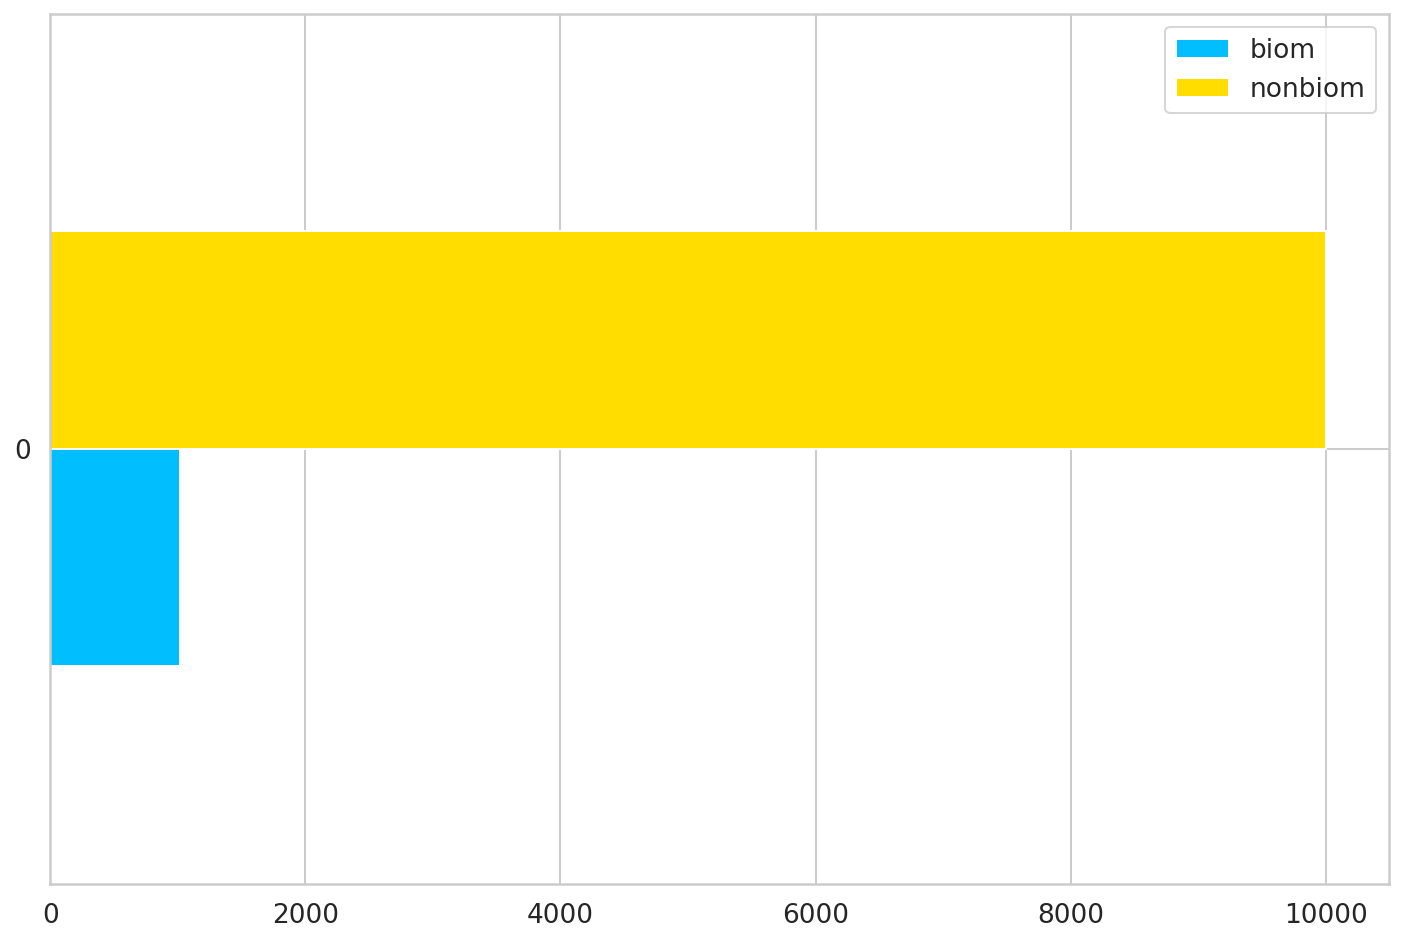

In [5]:
LABEL_COLUMNS = df.columns.tolist()[:-1]

biom = df[df[LABEL_COLUMNS].sum(axis=1) > 0]
nonbiom = df[df[LABEL_COLUMNS].sum(axis=1) == 0]

pd.DataFrame(dict(
  biom=[len(biom)], 
  nonbiom=[len(nonbiom)]
)).plot(kind='barh');

Pretty imbalanced so let's sample 1000 non-biomimicry papers to include and discard the rest.

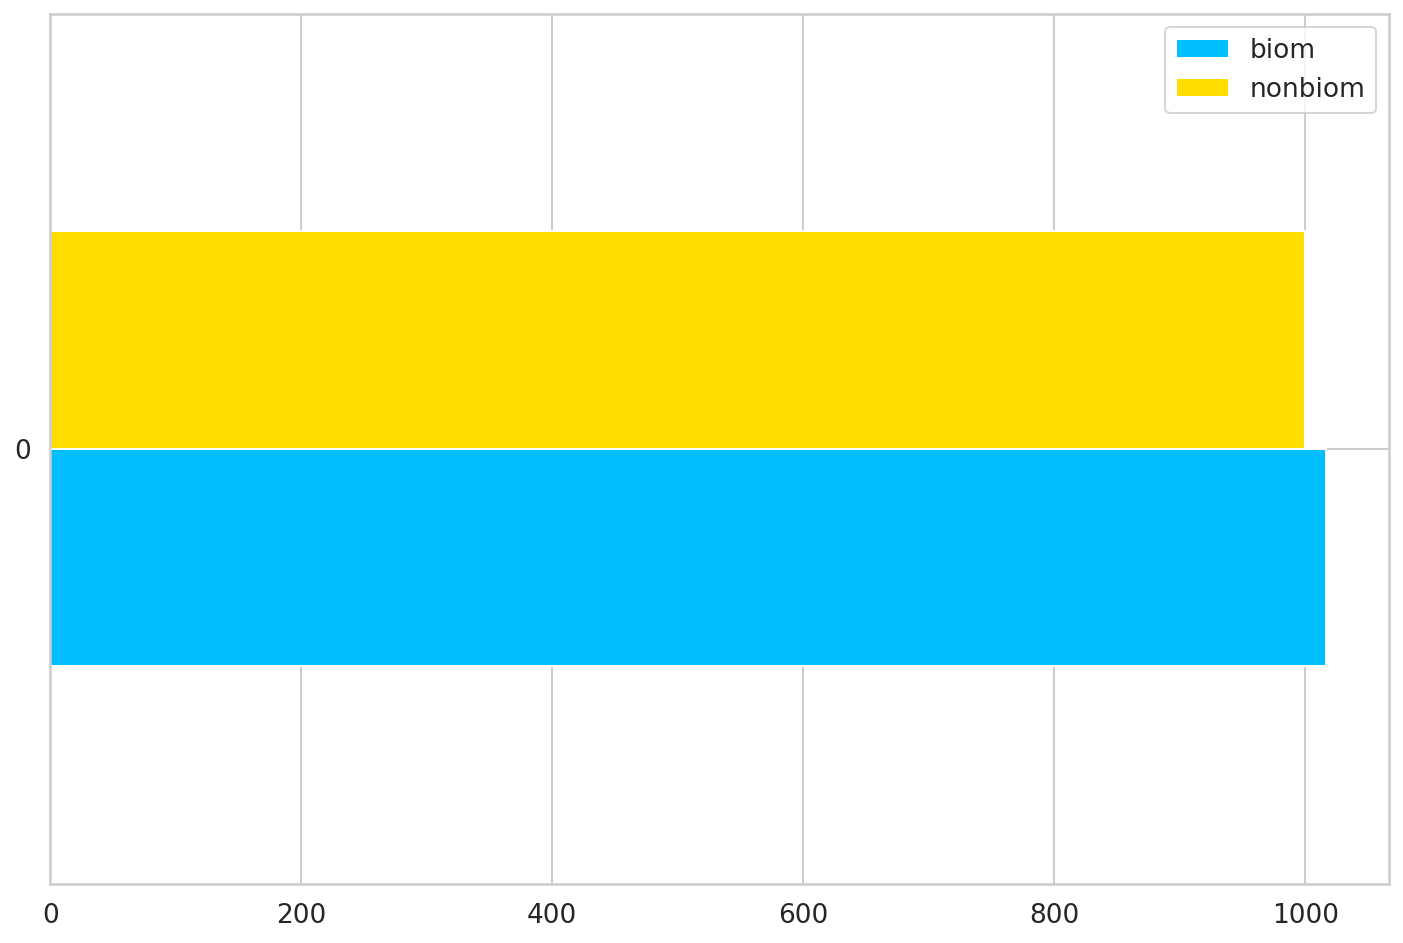

In [6]:
df = pd.concat([
  biom,
  nonbiom.sample(1000, random_state=RANDOM_SEED)
])

df.shape

biom = df[df[LABEL_COLUMNS].sum(axis=1) > 0]
nonbiom = df[df[LABEL_COLUMNS].sum(axis=1) == 0]

pd.DataFrame(dict(
  biom=[len(biom)], 
  nonbiom=[len(nonbiom)]
)).plot(kind='barh');

Much better. We have text (raw title and abstract) and leaf biomimicry labels.

Let's split the data:

In [7]:
from skmultilearn.model_selection import iterative_train_test_split

def iterative_train_test_split_dataframe(X, y, test_size):
    df_index = np.expand_dims(X.index.to_numpy(), axis=1)
    df_index_y = np.expand_dims(y.index.to_numpy(), axis=1)
    X_train, y_train, X_test, y_test = iterative_train_test_split(df_index, df_index_y, test_size = test_size)
    X_train = X.loc[X_train[:,0]]
    X_test = X.loc[X_test[:,0]]
    y_train = y.loc[y_train[:,0]]
    y_test = y.loc[y_test[:,0]]
    return X_train, y_train, X_test, y_test



X_train, y_train, X_test, y_test = iterative_train_test_split_dataframe(X=df[['text_raw']], y=df[LABEL_COLUMNS], test_size = 0.12)
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_test, y_test], axis=1)
#train_df, val_df = train_test_split(df, test_size=0.1)
train_df.shape, val_df.shape

((1774, 67), (242, 67))

## Preprocessing

Let's look at the distribution of the labels in the original datset, and the train and val splits:

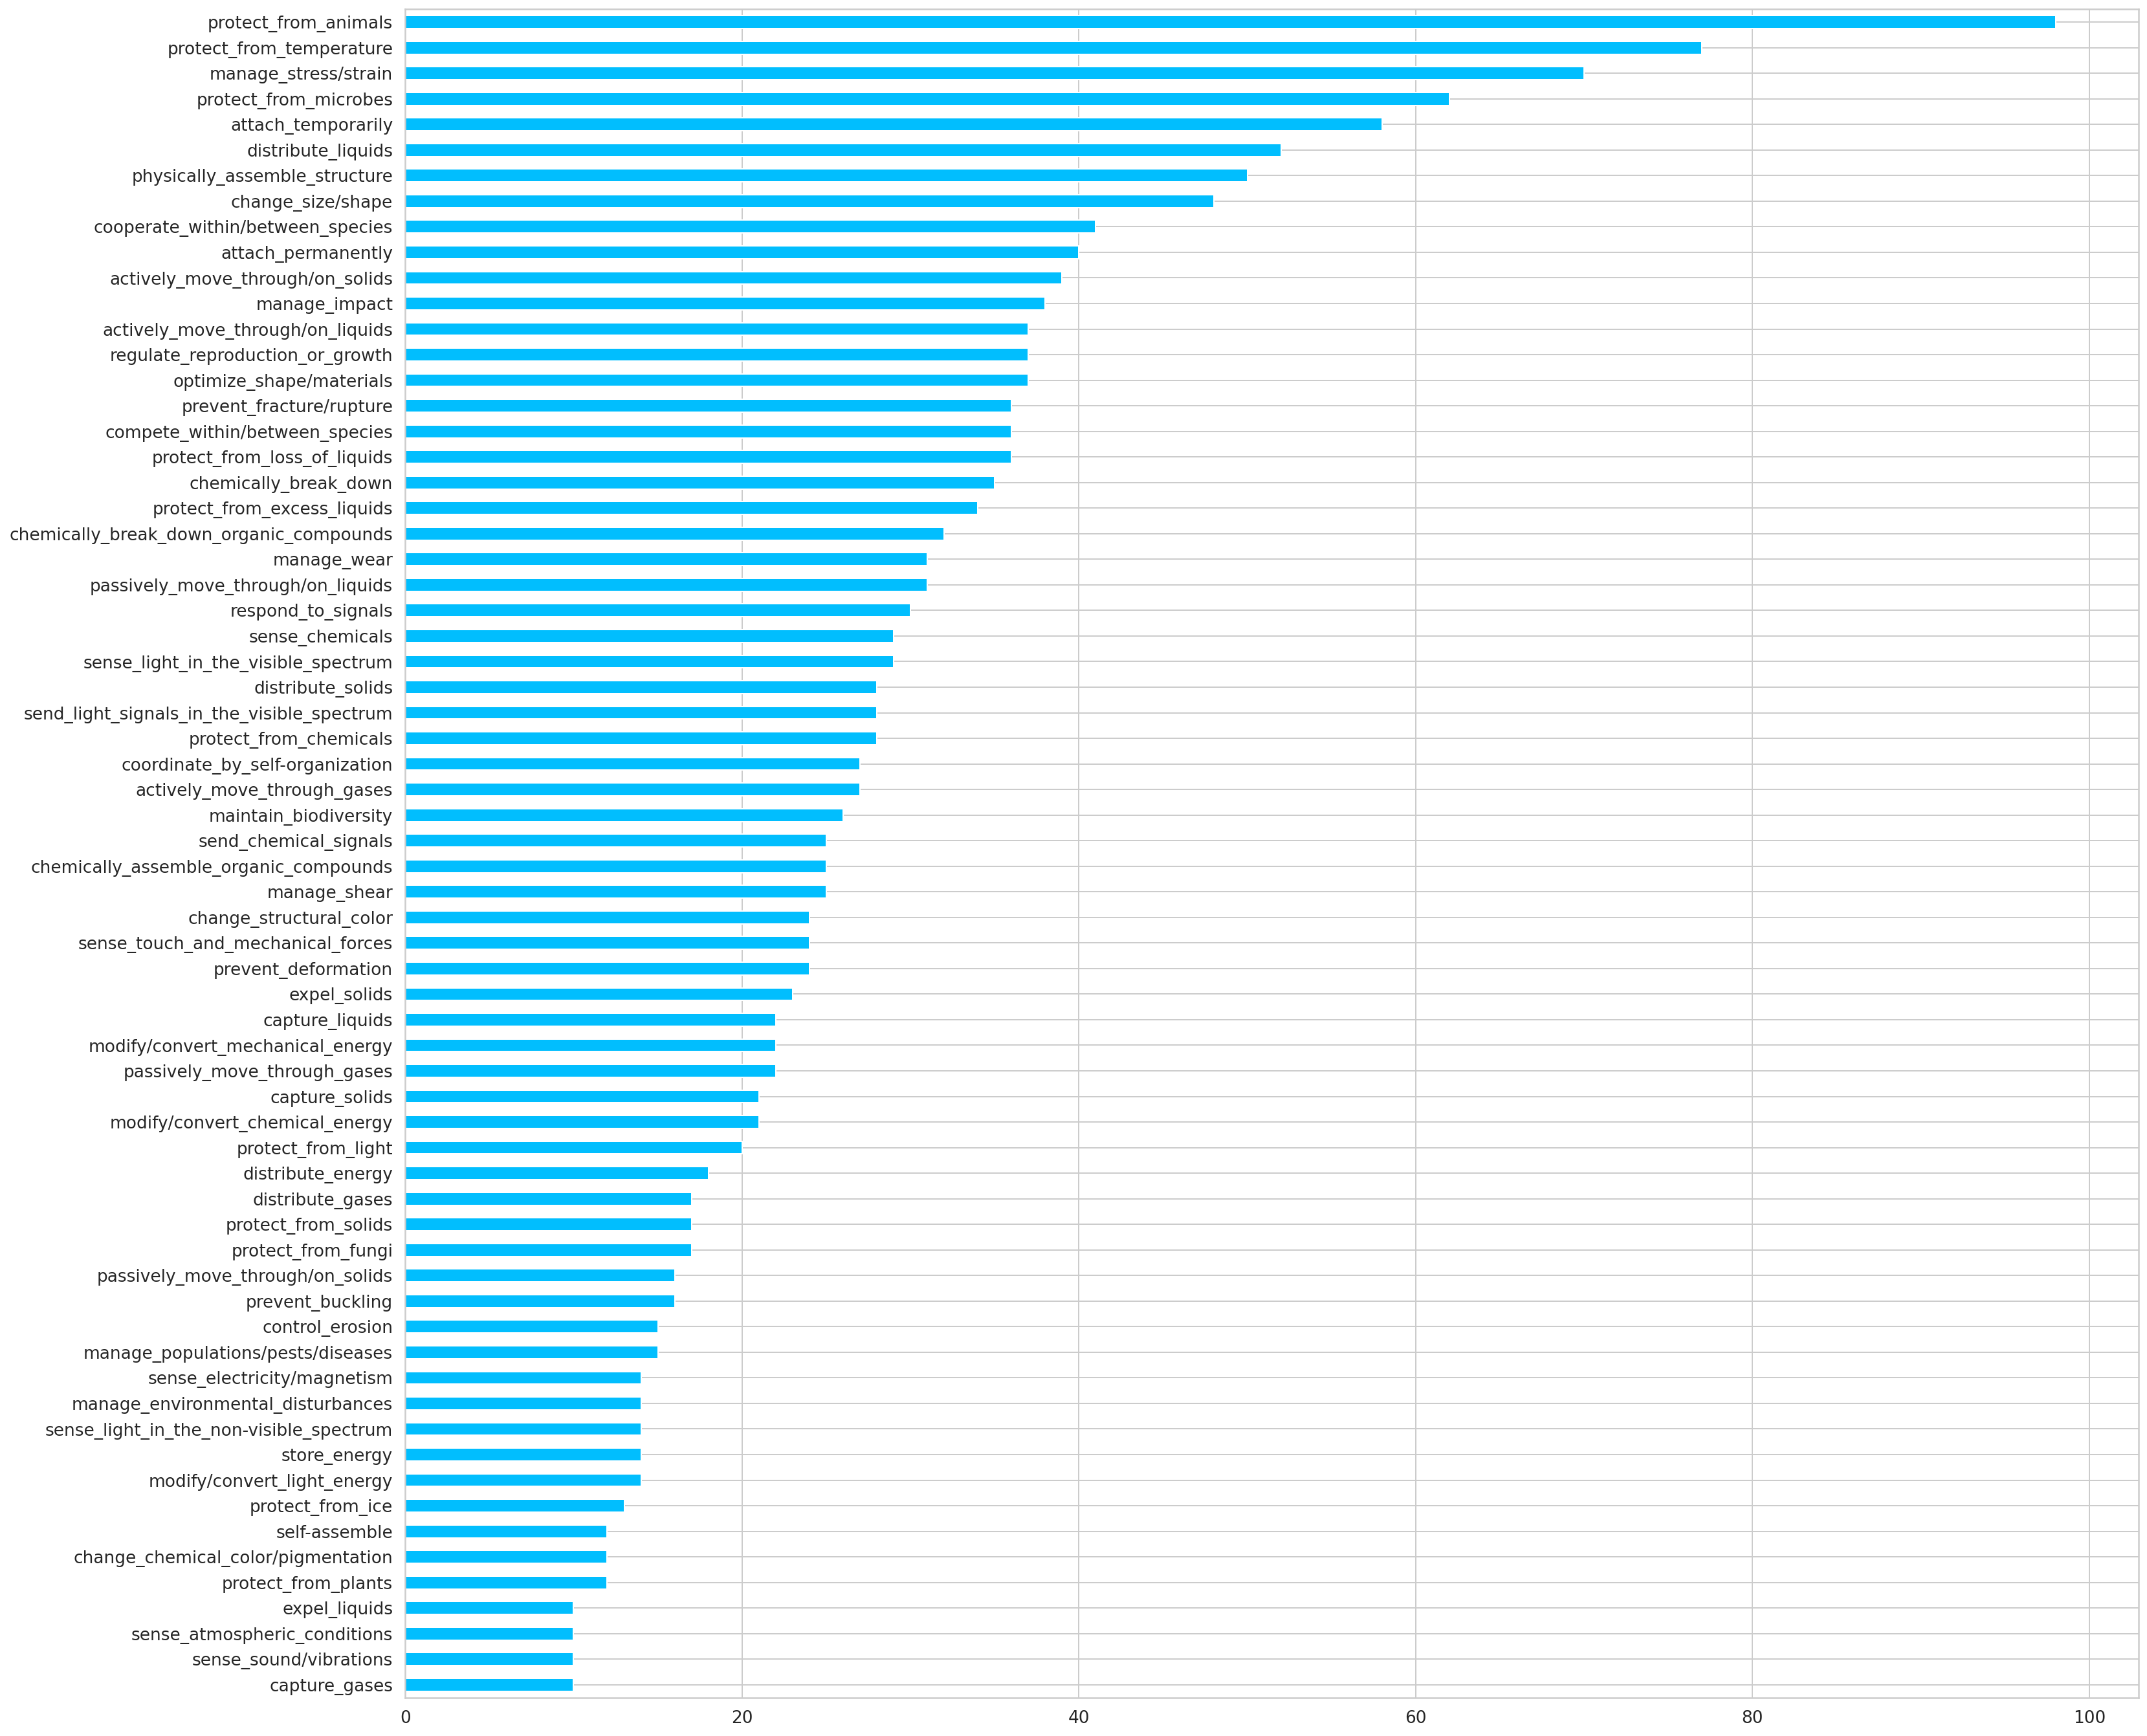

In [8]:
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh", figsize=(24, 24));

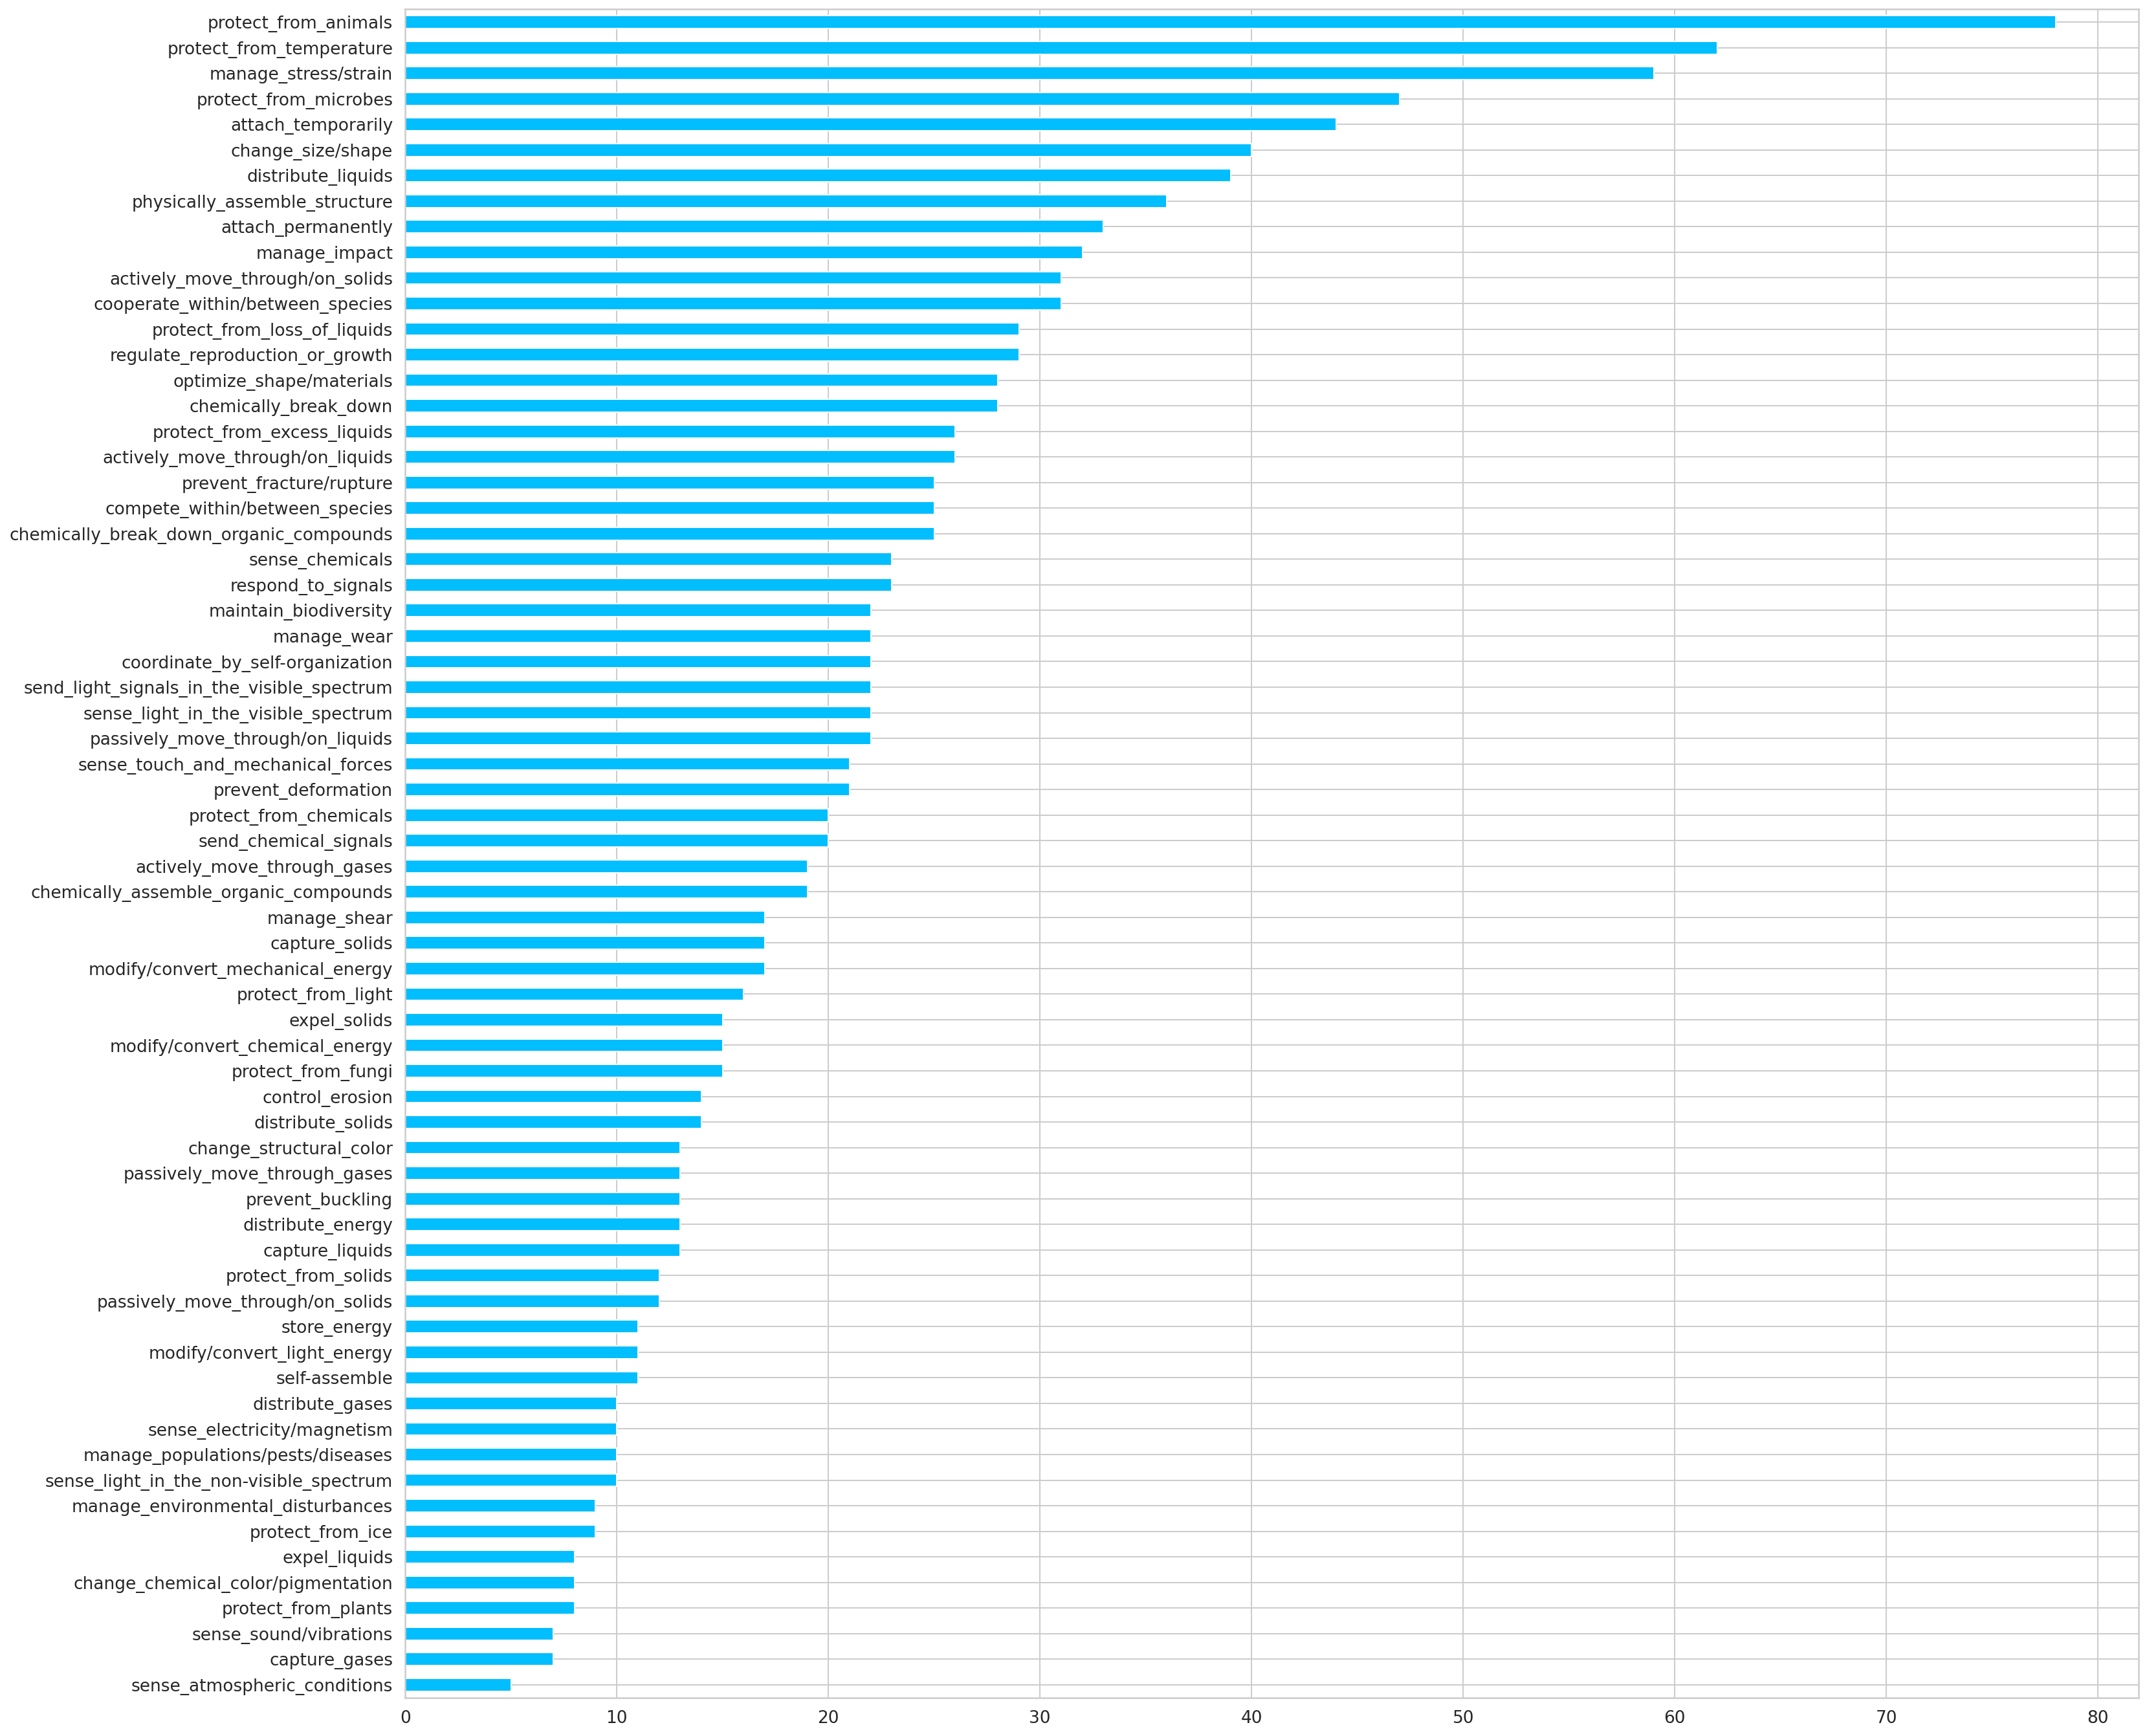

In [9]:
train_df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh", figsize=(24, 24));

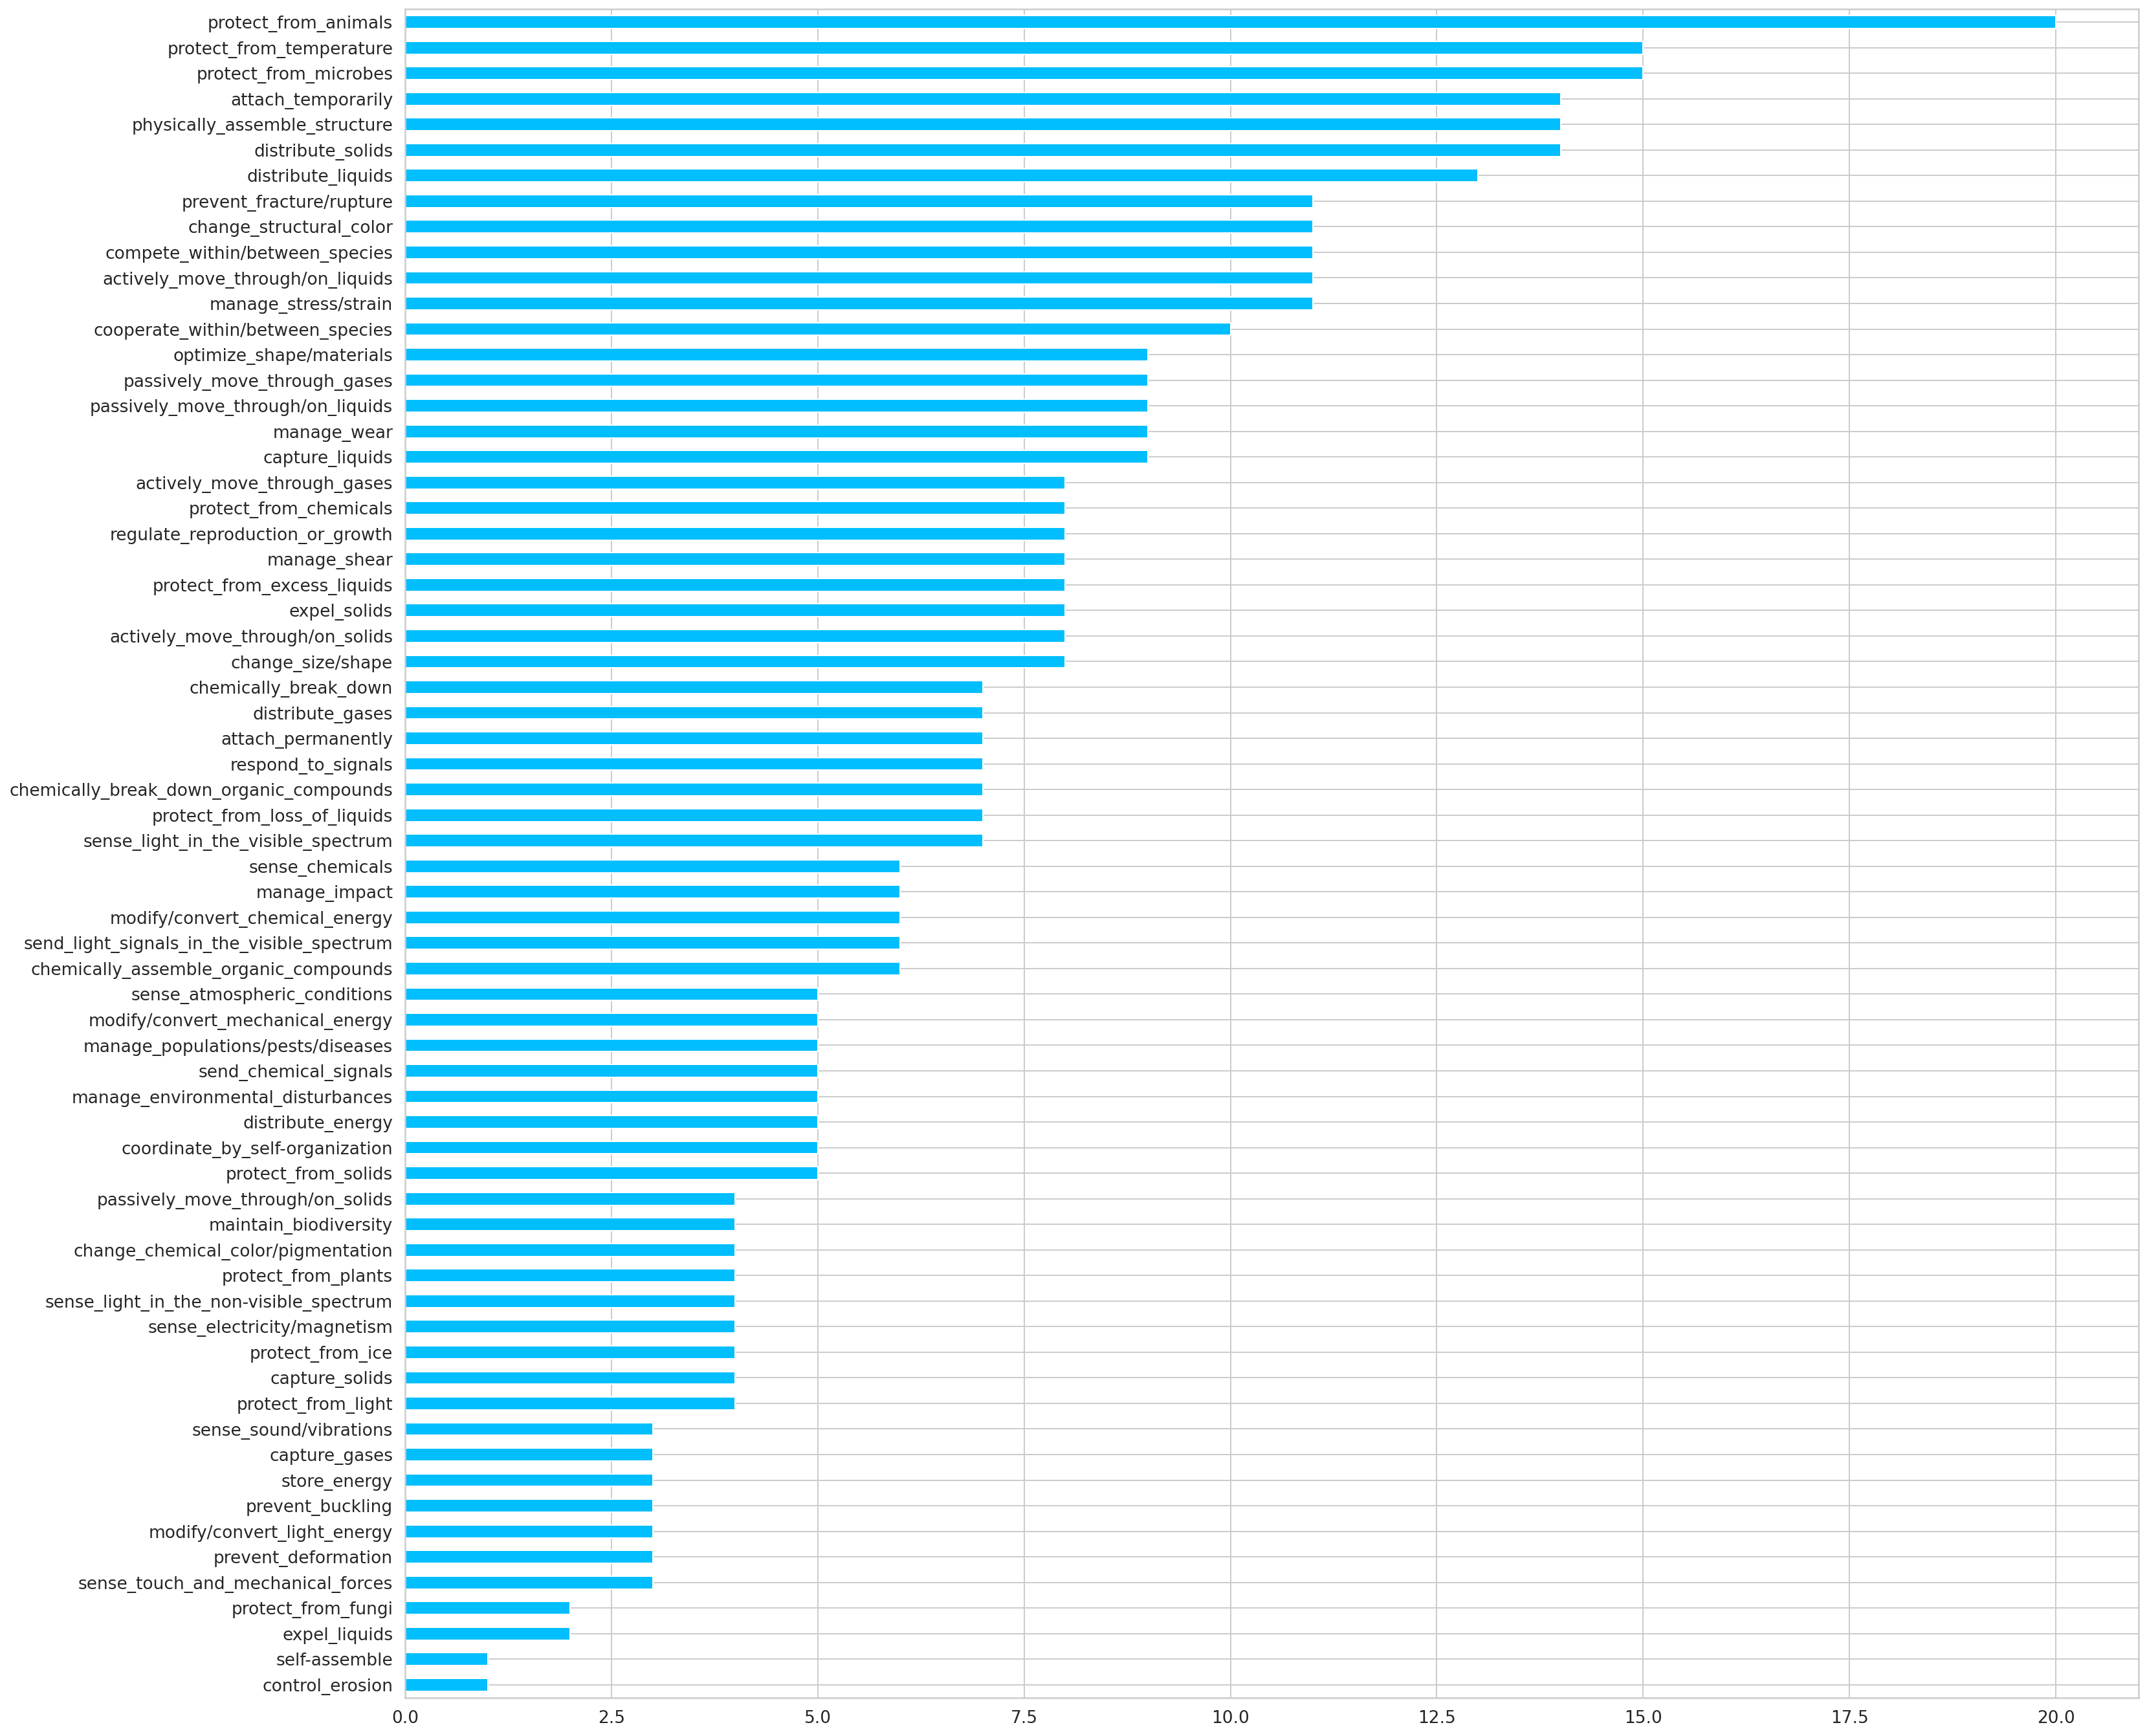

In [10]:
val_df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh", figsize=(24, 24));

We have a severe case of imbalance. But that is not the full picture. What about biomimicry vs non-biomimicry papers?

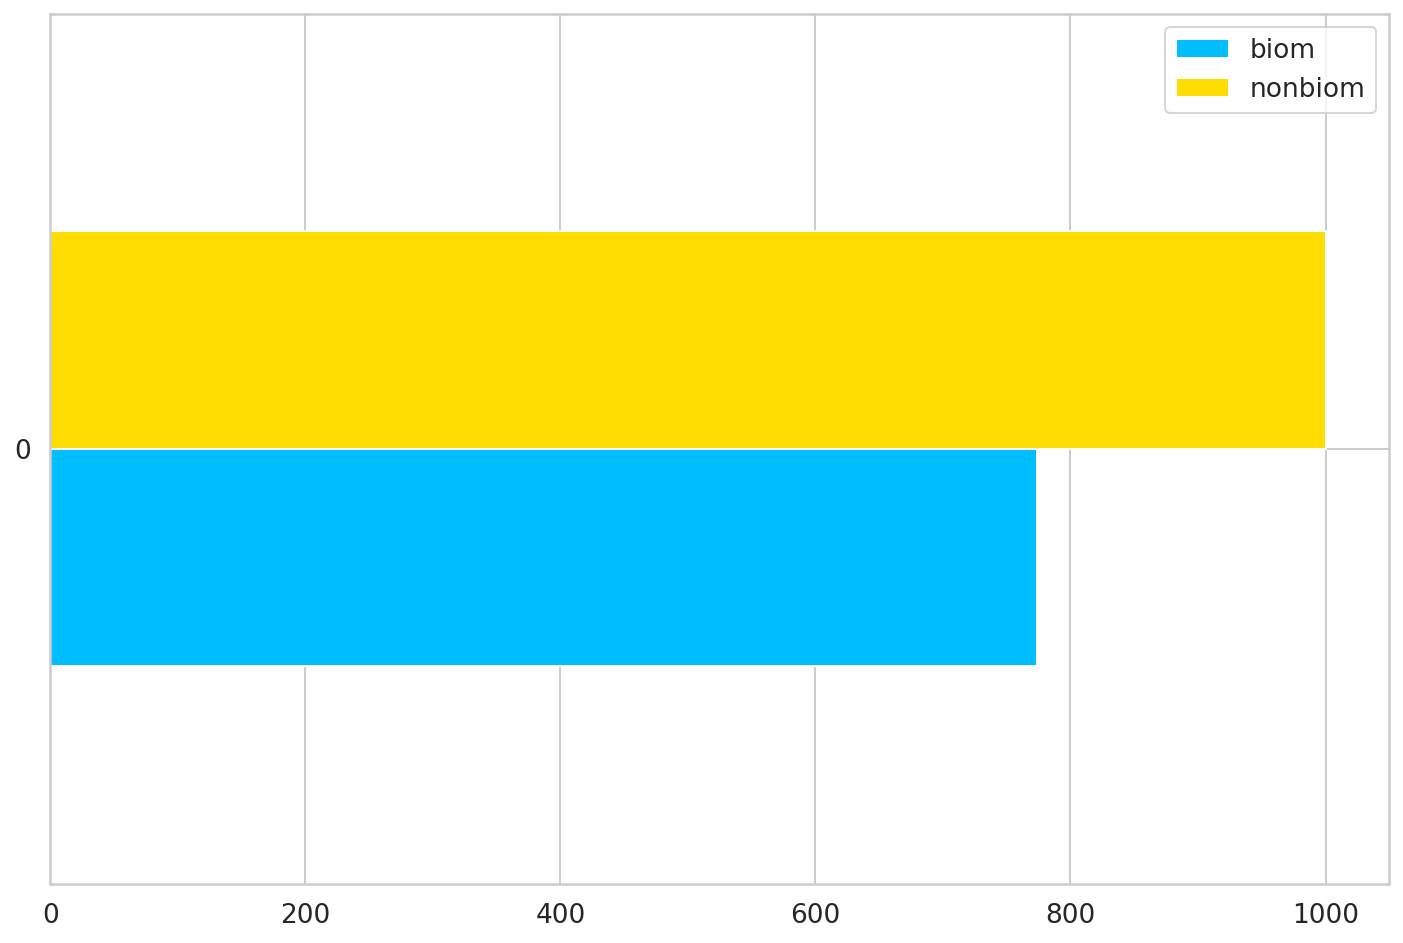

In [11]:
train_biom = train_df[train_df[LABEL_COLUMNS].sum(axis=1) > 0]
train_nonbiom = train_df[train_df[LABEL_COLUMNS].sum(axis=1) == 0]

pd.DataFrame(dict(
  biom=[len(train_biom)], 
  nonbiom=[len(train_nonbiom)]
)).plot(kind='barh');

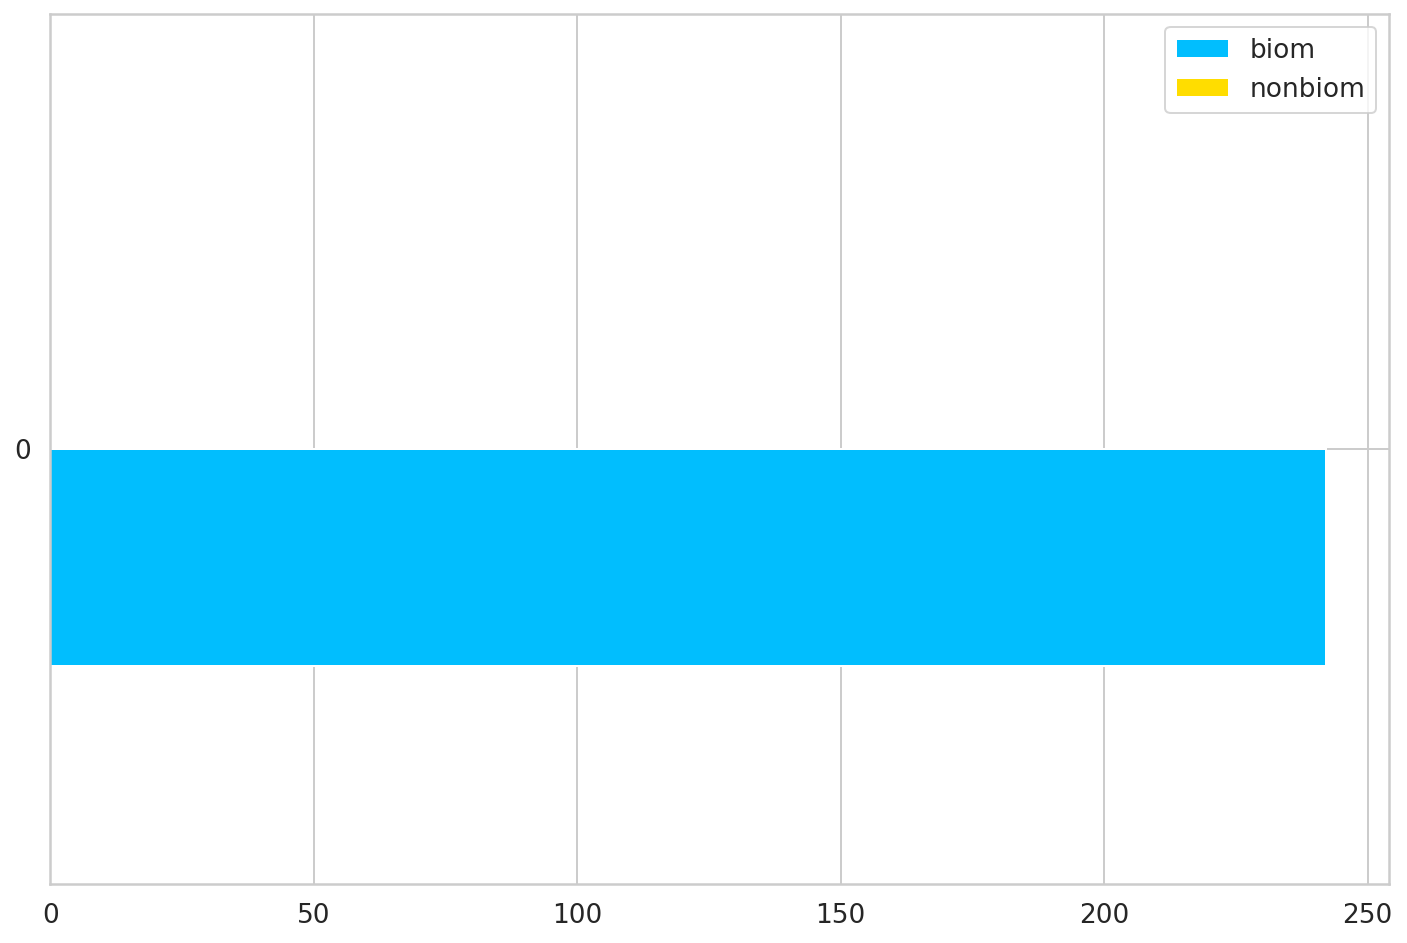

In [12]:
val_biom = val_df[val_df[LABEL_COLUMNS].sum(axis=1) > 0]
val_nonbiom = val_df[val_df[LABEL_COLUMNS].sum(axis=1) == 0]

pd.DataFrame(dict(
  biom=[len(val_biom)], 
  nonbiom=[len(val_nonbiom)]
)).plot(kind='barh');

Again, we have a severe imbalance in favor of the non-biomimicry papers in our training set and no nonbiom papers in our validation set. To fix this, we'll sample 500 examples from the non-biomimicry papers in the train set to keep in the train set, and the remainder we'll put in the validation set.

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


((1534, 67), (482, 67))

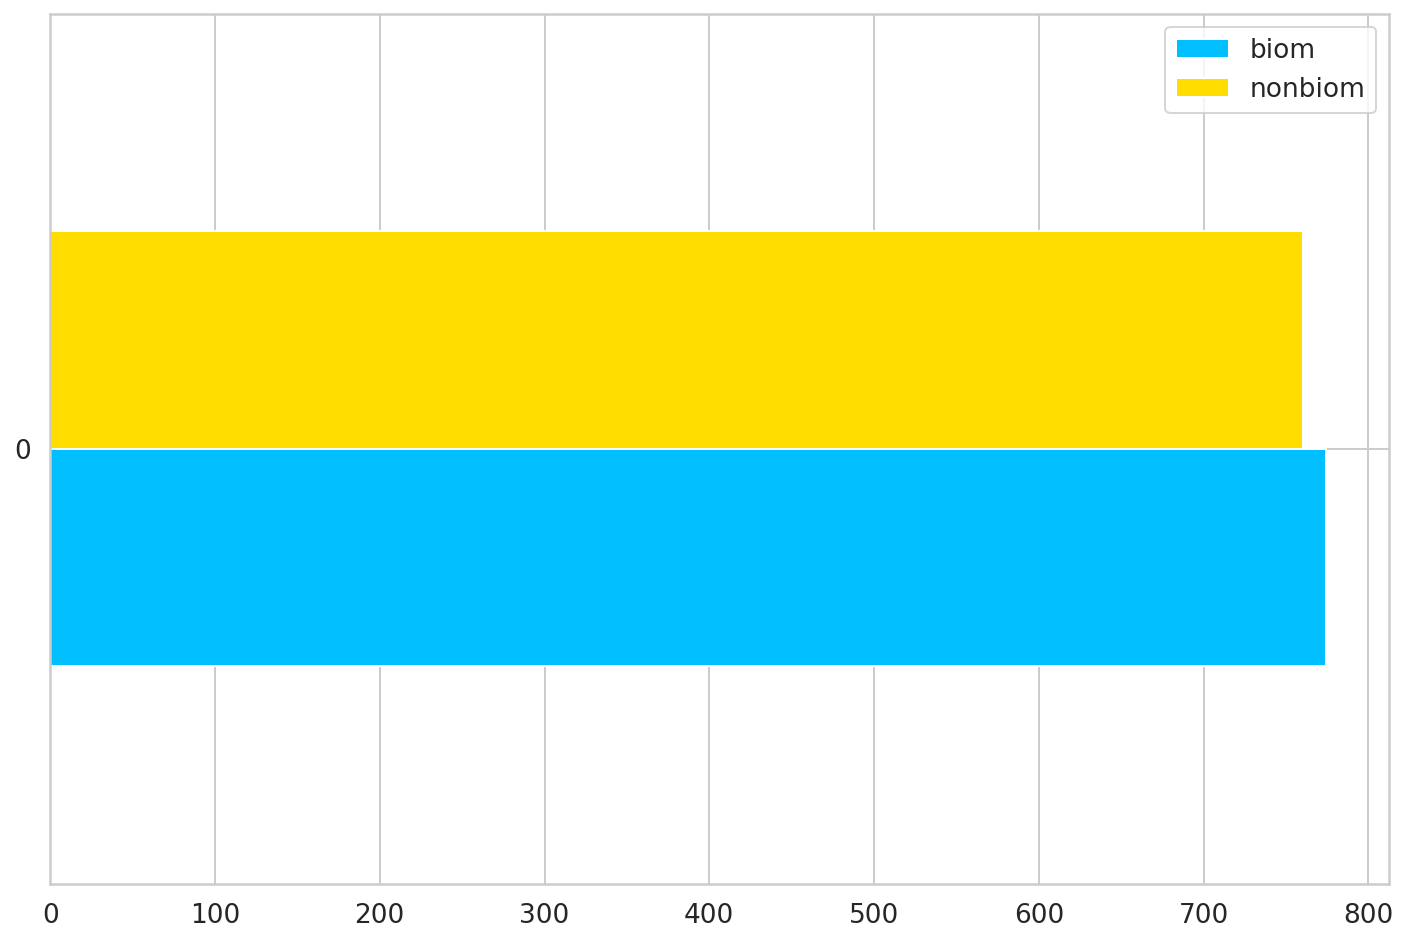

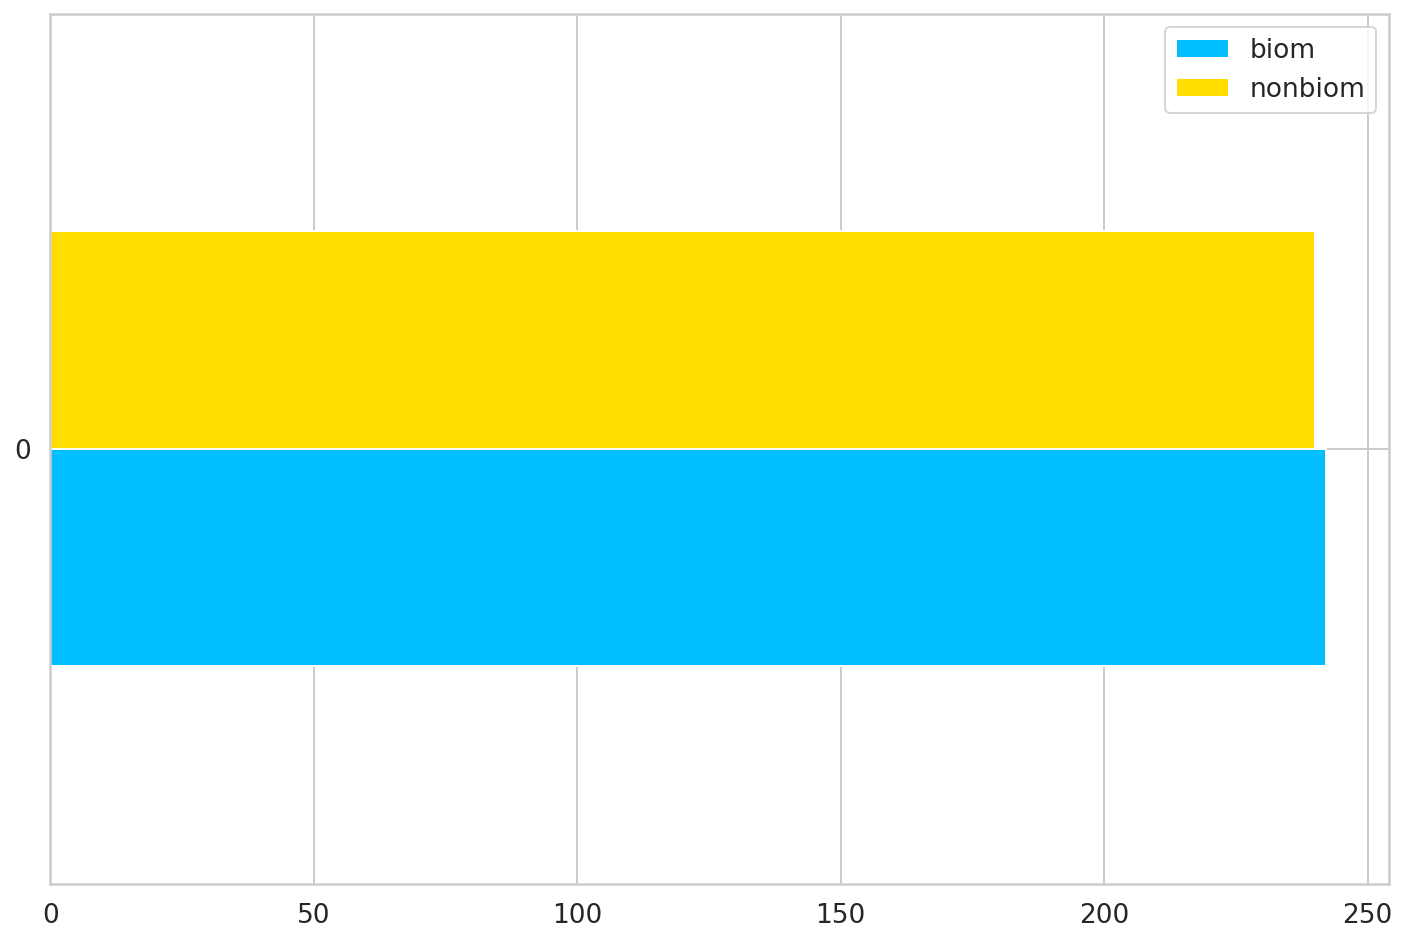

In [13]:
tns = train_nonbiom.sample(760, random_state=RANDOM_SEED)
train_nonbiom.drop(tns.index, inplace=True)

train_df = pd.concat([
  train_biom,
  tns
])

val_df = pd.concat([
  val_biom,
  train_nonbiom
])

train_biom = train_df[train_df[LABEL_COLUMNS].sum(axis=1) > 0]
train_nonbiom = train_df[train_df[LABEL_COLUMNS].sum(axis=1) == 0]

pd.DataFrame(dict(
  biom=[len(train_biom)], 
  nonbiom=[len(train_nonbiom)]
)).plot(kind='barh');

val_biom = val_df[val_df[LABEL_COLUMNS].sum(axis=1) > 0]
val_nonbiom = val_df[val_df[LABEL_COLUMNS].sum(axis=1) == 0]

pd.DataFrame(dict(
  biom=[len(val_biom)], 
  nonbiom=[len(val_nonbiom)]
)).plot(kind='barh');

train_df.shape, val_df.shape

### Tokenization

We need to convert the raw text into a list of tokens. For that, we'll use the built-in BertTokenizer:

In [14]:
BERT_MODEL_NAME = 'allenai/scibert_scivocab_uncased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/223k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Let's try it out on a sample paper:

In [15]:
sample_row = df.iloc[16]
sample_comment = sample_row.text_raw
sample_labels = sample_row[LABEL_COLUMNS]

print(sample_comment)
print()
print(sample_labels.to_dict())

Bacterial Recognition of Mineral Surfaces: Nanoscale Interactions Between Shewanella and α-FeOOH. Force microscopy has been used to quantitatively measure the infinitesimal forces that characterize interactions betweenShewanella oneidensis (a dissimilatory metal-reducing bacterium) and goethite (α-FeOOH), both commonly found in Earth near-surface environments. Force measurements with subnanonewton resolution were made in real time with living cells under aerobic and anaerobic solutions as a function of the distance, in nanometers, between a cell and the mineral surface. Energy values [in attojoules (10−18 joules)] derived from these measurements show that the affinity between S. oneidensis and goethite rapidly increases by two to five times under anaerobic conditions in which electron transfer from bacterium to mineral is expected. Specific signatures in the force curves suggest that a 150-kilodalton putative iron reductase is mobilized within the outer membrane of S. oneidensis and sp

In [16]:
encoding = tokenizer.encode_plus(
  sample_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [17]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

The result of the encoding is a dictionary with token ids `input_ids` and an attention mask `attention_mask` (which tokens should be used by the model 1 - use or 0 - don't use).

Let's look at their contents:

In [18]:
encoding["input_ids"].squeeze()[:20]

tensor([  102,  4667,  3512,   131,  7921,  5347,   862, 20083,  2697,   467,
         2281,  8013,  5154,   137,  1474,   579,   588,  7291, 30117,   205])

In [19]:
encoding["attention_mask"].squeeze()[:20]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

You can also inverse the tokenization and get back (kinda) the words from the token ids:

In [20]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])

['[CLS]', 'bacterial', 'recognition', 'of', 'mineral', 'surfaces', ':', 'nanoscale', 'interactions', 'between', 'she', '##wan', '##ella', 'and', 'α', '-', 'fe', '##oo', '##h', '.']


We need to specify the maximum number of tokens when encoding (512 is the maximum we can do). Let's check the number of tokens per paper:

In [21]:
token_counts = []

for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["text_raw"], 
    max_length=512, 
    truncation=True
  ))
  token_counts.append(token_count)

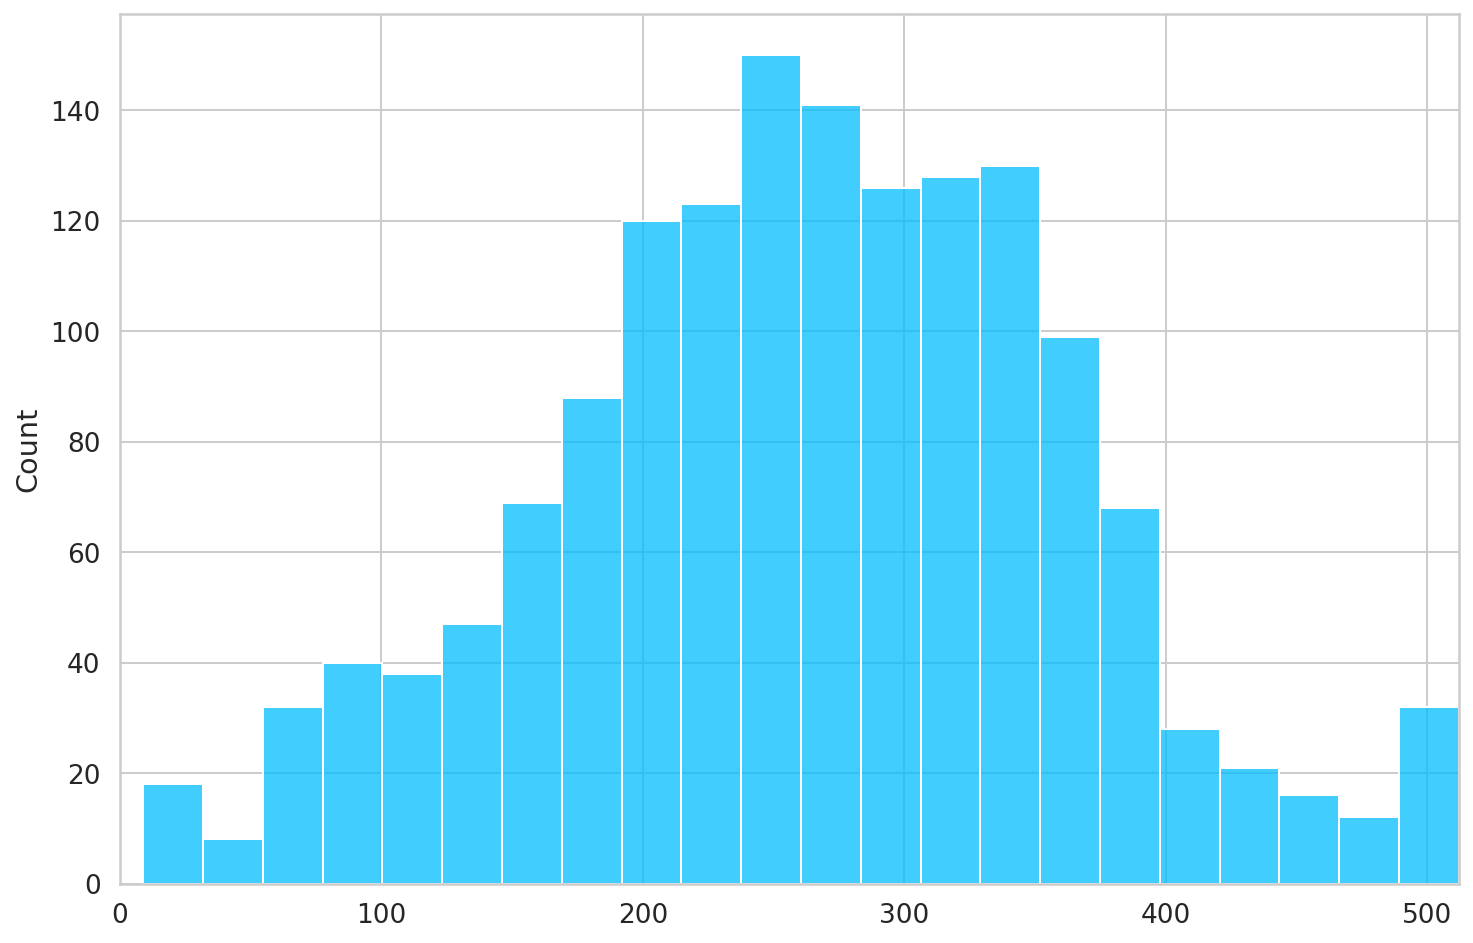

In [22]:
sns.histplot(token_counts)
plt.xlim([0, 512]);

Most of the papers contain less than 400 tokens or more than 512. So, we'll stick with the limit of 512.

In [23]:
MAX_TOKEN_COUNT = 256 #512 runs out of memory on colab, 400 runs out too.

### Dataset

We'll wrap the tokenization process in a PyTorch Dataset, along with converting the labels to tensors:

In [24]:
class BiomimicryDataset(Dataset):

  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: BertTokenizer, 
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    text = data_row.text_raw
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      text=text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

Let's have a look at a sample item from the dataset:

In [25]:
train_dataset = BiomimicryDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'labels'])

In [26]:
sample_item["text"]

"Building a home from foam—túngara frog foam nest architecture and three-phase construction process. Frogs that build foam nests floating on water face the problems of over-dispersion of the secretions used and eggs being dangerously exposed at the foam : air interface. Nest construction behaviour of túngara frogs, Engystomops pustulosus, has features that may circumvent these problems. Pairs build nests in periodic bursts of foam production and egg deposition, three discrete phases being discernible. The first is characterized by a bubble raft without egg deposition and an approximately linear increase in duration of mixing events with time. This phase may reduce initial over-dispersion of foam precursor materials until a critical concentration is achieved. The main building phase is marked by mixing events and start-to-start intervals being nearly constant in duration. During the final phase, mixing events do not change in duration but intervals between them increase in an exponentia

In [27]:
sample_item["labels"]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.])

In [28]:
sample_item["input_ids"].shape

torch.Size([256])

Let's load the BERT model and pass a sample of batch data through:

In [29]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=2)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([8, 256]), torch.Size([8, 256]))

In [31]:
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])

In [32]:
output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([8, 256, 768]), torch.Size([8, 768]))

The `768` dimension comes from the BERT hidden size:

In [33]:
bert_model.config.hidden_size

768

The larger version of BERT has more attention heads and a larger hidden size.

We'll wrap our custom dataset into a [LightningDataModule](https://pytorch-lightning.readthedocs.io/en/stable/extensions/datamodules.html):

In [34]:
class BiomimicryDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = BiomimicryDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = BiomimicryDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

`BiomimicryDataModule` encapsulates all data loading logic and returns the necessary data loaders. Let's create an instance of our data module:

In [35]:
N_EPOCHS = 15
BATCH_SIZE = 12

data_module = BiomimicryDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

## Model

Our model will use a pre-trained [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and a linear layer to convert the BERT representation to a classification task. We'll pack everything in a [LightningModule](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html):


In [36]:
class BiomimicryTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)    
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):
    
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i],  labels[:, i])
      #class_ap = average_precision(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
      #self.logger.experiment.add_scalar(f"{name}_ap/Train", class_ap, self.current_epoch)


  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

Most of the implementation is just a boilerplate. Two points of interest are the way we configure the optimizers and calculating the area under ROC. We'll dive a bit deeper into those next.

### Optimizer scheduler

The job of a scheduler is to change the learning rate of the optimizer during training. This might lead to better performance of our model. We'll use the [get_linear_schedule_with_warmup](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#transformers.get_linear_schedule_with_warmup).

Let's have a look at a simple example to make things clearer:

In [37]:
dummy_model = nn.Linear(2, 1)

optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)

warmup_steps = 20
total_training_steps = 100

scheduler = get_linear_schedule_with_warmup(
  optimizer, 
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)

learning_rate_history = []

for step in range(total_training_steps):
  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])

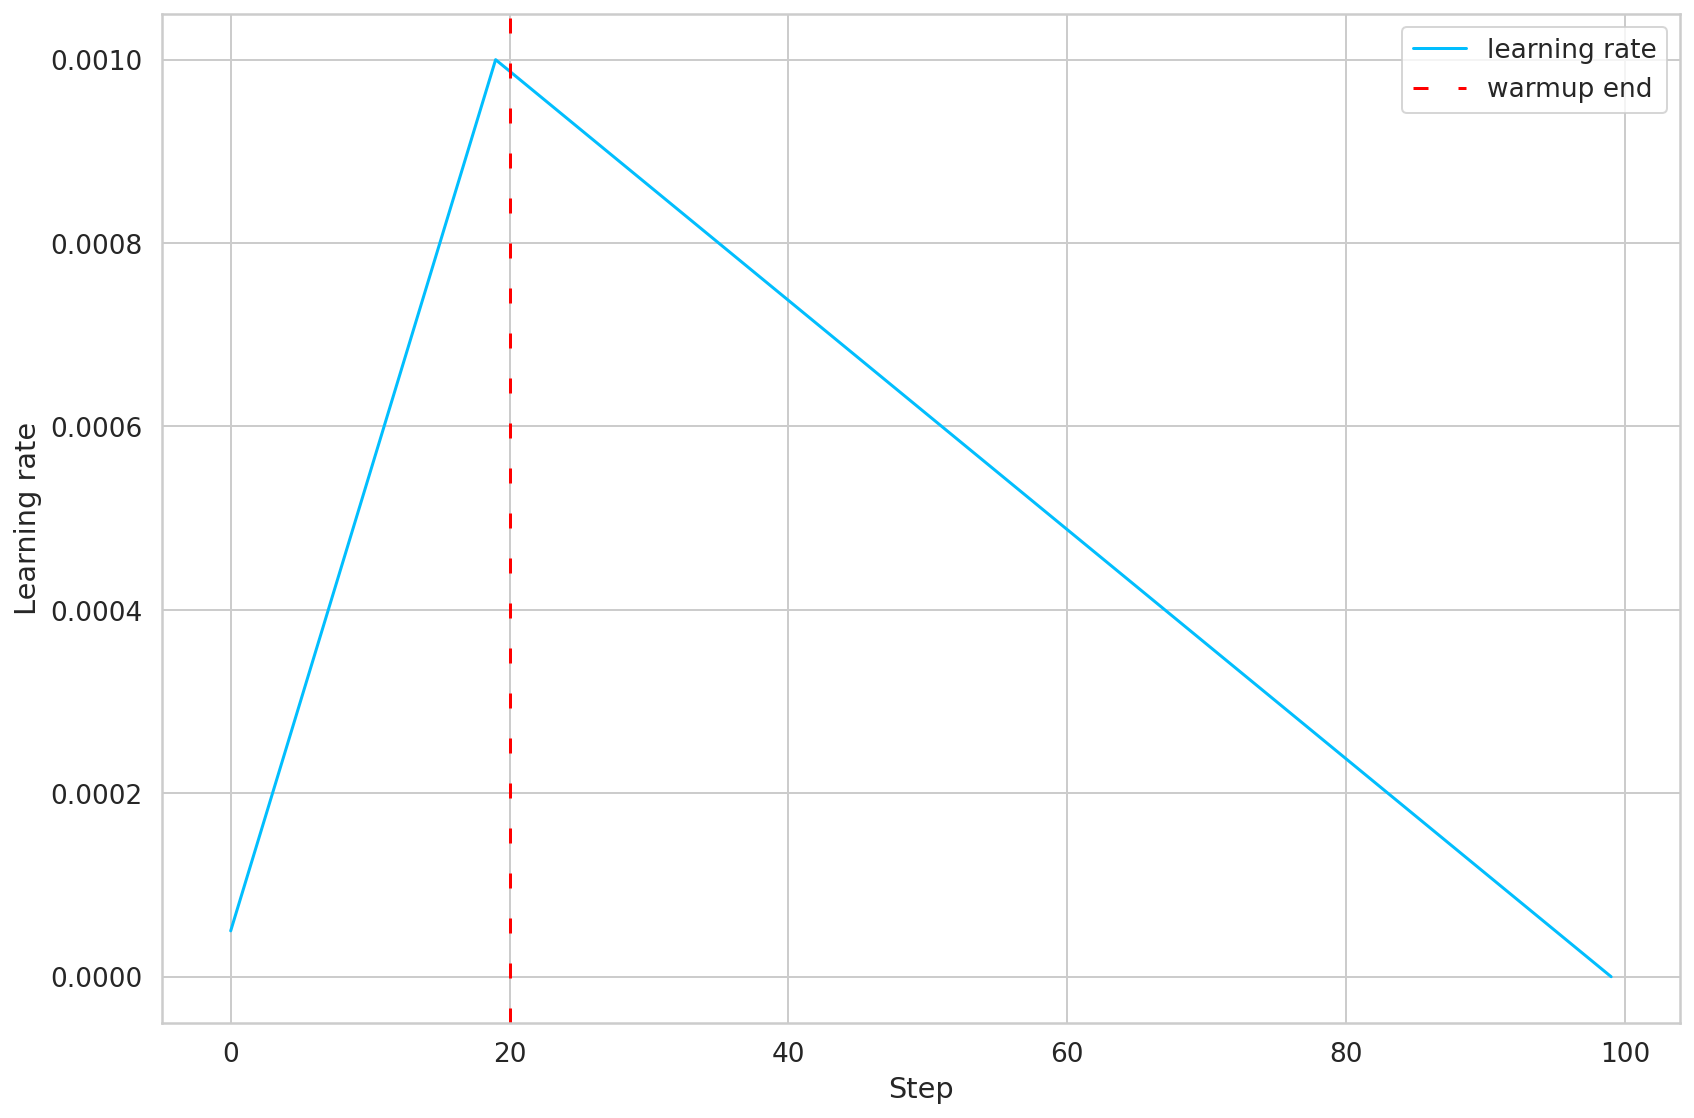

In [38]:
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();

We simulate 100 training steps and tell the scheduler to warm up for the first 20. The learning rate grows to the initial fixed value of 0.001 during the warm-up and then goes down (linearly) to 0.

To use the scheduler, we need to calculate the number of training and warm-up steps. The number of training steps per epoch is equal to `number of training examples / batch size`. The number of total training steps is `training steps per epoch * number of epochs`:

In [39]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

We'll use a fifth of the training steps for a warm-up:

In [40]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(381, 1905)

We can now create an instance of our model:

In [41]:
model = BiomimicryTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps 
)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Evaluation

Multi-label classification boils down to doing binary classification for each label/tag.

We'll use Binary Cross Entropy to measure the error for each label. PyTorch has [BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), which we're going to combine with a sigmoid function (as we did in the model implementation). Let's look at an example:

In [42]:
criterion = nn.BCELoss()

prediction = torch.FloatTensor(
  [10.95873564, 1.07321467, 1.58524066, 0.03839076, 15.72987556, 1.09513213, 1.58524066, 0.03839076, 15.72987556, 1.09513213]
)
labels = torch.FloatTensor(
  [1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]
) 

In [43]:
torch.sigmoid(prediction)

tensor([1.0000, 0.7452, 0.8299, 0.5096, 1.0000, 0.7493, 0.8299, 0.5096, 1.0000,
        0.7493])

In [44]:
criterion(torch.sigmoid(prediction), labels)

tensor(0.9103)

We can use the same approach to calculate the loss of the predictions:

In [45]:
_, predictions = model(sample_batch["input_ids"], sample_batch["attention_mask"])
predictions

tensor([[0.3911, 0.5199, 0.5691, 0.4914, 0.5561, 0.5138, 0.4711, 0.6552, 0.5393,
         0.5520, 0.4813, 0.4196, 0.5110, 0.6331, 0.4992, 0.5428, 0.3238, 0.5066,
         0.4567, 0.4257, 0.3885, 0.5696, 0.3997, 0.3764, 0.4398, 0.6980, 0.6754,
         0.4658, 0.4385, 0.5395, 0.5362, 0.4850, 0.6231, 0.6023, 0.6232, 0.5901,
         0.7011, 0.3845, 0.3955, 0.4951, 0.6656, 0.5415, 0.3870, 0.4752, 0.4830,
         0.5330, 0.3019, 0.4424, 0.4614, 0.5193, 0.4338, 0.5722, 0.3151, 0.4609,
         0.6101, 0.3342, 0.4812, 0.3975, 0.4194, 0.5168, 0.5621, 0.4403, 0.6586,
         0.3936, 0.4224, 0.3656],
        [0.4144, 0.4978, 0.5875, 0.4365, 0.5633, 0.4665, 0.5447, 0.6708, 0.5615,
         0.4857, 0.3574, 0.3904, 0.5222, 0.6707, 0.4965, 0.5299, 0.3184, 0.5316,
         0.4506, 0.4657, 0.4617, 0.5587, 0.4302, 0.4358, 0.4597, 0.6570, 0.7233,
         0.4742, 0.4826, 0.5027, 0.5065, 0.4111, 0.5955, 0.6637, 0.6386, 0.5876,
         0.6587, 0.3696, 0.4232, 0.4838, 0.7563, 0.5232, 0.5362, 0.4516, 0.

In [46]:
criterion(predictions, sample_batch["labels"])

tensor(0.7145, grad_fn=<BinaryCrossEntropyBackward0>)

#### ROC Curve

Another metric we're going to use is the area under the Receiver operating characteristic (ROC) for each tag. ROC is created by plotting the True Positive Rate (TPR) vs False Positive Rate (FPR):

$$
\text{TPR} = \frac{\text{TP}}{\text{TP} \text{+} \text{FN}}
$$

$$
\text{FPR} = \frac{\text{FP}}{\text{FP} \text{+} \text{TN}}
$$




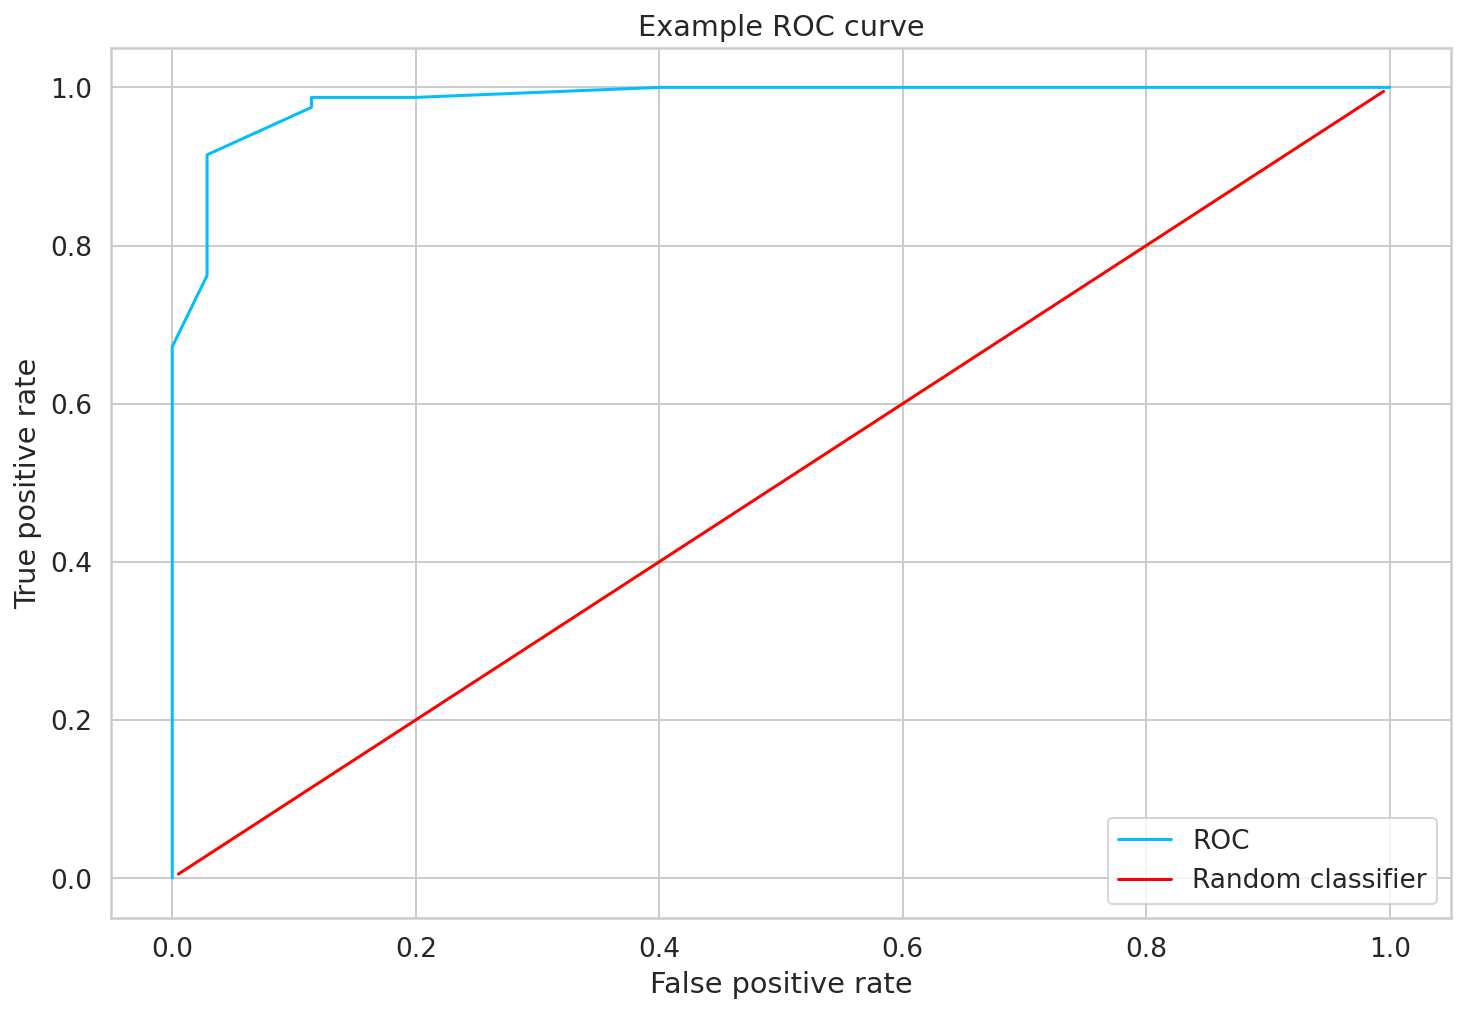

In [47]:
from sklearn import metrics

fpr = [0.        , 0.        , 0.        , 0.02857143, 0.02857143,
       0.11428571, 0.11428571, 0.2       , 0.4       , 1.        ]

tpr = [0.        , 0.01265823, 0.67202532, 0.76202532, 0.91468354,
       0.97468354, 0.98734177, 0.98734177, 1.        , 1.        ]

_, ax = plt.subplots()
ax.plot(fpr, tpr, label="ROC")
ax.plot([0.05, 0.95], [0.05, 0.95], transform=ax.transAxes, label="Random classifier", color="red")
ax.legend(loc=4)
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("Example ROC curve")
plt.show();

## Training

In [48]:
!rm -rf lightning_logs/
!rm -rf checkpoints/

In [49]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

<IPython.core.display.Javascript object>

The beauty of PyTorch Lightning is that you can build a standard pipeline that you like and train (almost?) every model you might imagine. I prefer to use at least 3 components.

Checkpointing that saves the best model (based on validation loss):

In [50]:
#from google.colab import drive
#drive.mount('/content/gdrive')

#model_folder = '/content/gdrive/My Drive/petal-search-engine/models/'

In [51]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

'''
checkpoint_callback = ModelCheckpoint(
  dirpath=model_folder,
  filename="scibert-leaves",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)
'''

'\ncheckpoint_callback = ModelCheckpoint(\n  dirpath=model_folder,\n  filename="scibert-leaves",\n  save_top_k=1,\n  verbose=True,\n  monitor="val_loss",\n  mode="min"\n)\n'

Log the progress in TensorBoard:

In [52]:
logger = TensorBoardLogger("lightning_logs", name="biomimicry-papers")

And early stopping triggers when the loss hasn't improved for the last 2 epochs (you might want to remove/reconsider this when training on real-world projects):

In [53]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

We can start the training process:

In [54]:
trainer = pl.Trainer(
  logger=logger,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
  progress_bar_refresh_rate=30
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7fd69288d250>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7fd69288d250>)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Tr

In [55]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 109 M 
1 | classifier | Linear    | 50.8 K
2 | criterion  | BCELoss   | 0     
-----------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
439.877   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1187. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 998. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
Global seed set to 42


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/optimization/closure.py:36: LightningDeprecationWarning: One of the returned values {'predictions', 'labels'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2781. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 493. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 878. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an am

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

The model improved for 8 epochs. We'll have to evaluate it to see whether it is any good. Let's double-check the validation loss:

In [56]:
#trainer.test() #this generates an error for some reason.

## Predictions

I like to look at a small sample of predictions after the training is complete. This builds intuition about the quality of the predictions (qualitative evaluation).

Let's load the best version (according to the validation loss) of our model:

In [57]:
trained_model = BiomimicryTagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


We put our model into "eval" mode, and we're ready to make some predictions. Here's the prediction on a sample paper:

In [58]:
test_comment = "Cutin and Cutan Biopolymers: Their Role as Natural Sorbents. The aliphatic biopolymers cutin and cutan are important precursors of soil organic matter. In this study, we examined the effects of these biopolymers' decomposition and transformation in the soil on their sorptive properties. The levels of cutin and cutan decreased by 35 and 30%, respectively, after 20 mo of incubation. Carbon-13 nuclear magnetic resonance and differential scanning calorimeter analyses suggested that the rigid (crystalline) polymethylene moieties of cutan decompose with time. This observation is in contrast to previous reports, which suggested that this alkyl-C moiety is resistant to biodegradation. Cutin, however, exhibited mainly decomposition of the mobile (amorphous) polymethylene moieties. Moreover, some of its degraded materials were transformed into humic materials. The phenanthrene sorption coefficient decreased by 80 and 37% with incubation time of the cutin and cutan samples, respectively. For 1-naphthol, the sorption capacity decreased by 90% due to cutin decomposition. With cutan, this parameter did not show any changes correlated with incubation time. Phenanthrene exhibited linear and reversible sorption isotherms. In contrast, pronounced desorption hysteresis was obtained for 1-naphthol with the 20-mo-incubated cutin sample and with all cutan samples. With all cutan samples, desorption hysteresis increased with decomposition. Our data suggest that the sorptive nature of both biopolymers was affected by soil decomposition. With degradation, the role of cutin as a natural sorbent decreases while cutan acts as a natural highly efficient sorbent for organic compounds in the soil."

encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  print(f"{label}: {prediction}")

manage_shear: 0.012859400361776352
change_chemical_color/pigmentation: 0.008867716416716576
modify/convert_light_energy: 0.011800296604633331
sense_light_in_the_visible_spectrum: 0.01585444249212742
prevent_buckling: 0.011059715412557125
send_light_signals_in_the_visible_spectrum: 0.014740901999175549
respond_to_signals: 0.01658918708562851
store_energy: 0.011358237825334072
expel_liquids: 0.009787341579794884
coordinate_by_self-organization: 0.015874871984124184
sense_chemicals: 0.01614544168114662
passively_move_through/on_liquids: 0.01594669558107853
passively_move_through_gases: 0.011501951143145561
passively_move_through/on_solids: 0.011893102899193764
maintain_biodiversity: 0.014992712065577507
attach_temporarily: 0.028299758210778236
modify/convert_chemical_energy: 0.011780251748859882
protect_from_fungi: 0.012773058377206326
compete_within/between_species: 0.01701243221759796
change_structural_color: 0.011810042895376682
actively_move_through_gases: 0.013613617047667503
sense_l

"process resources" followed by "chemically modify or change energy state". That seems like a great prediction! Let's look at another paper.





In [59]:
THRESHOLD = 0.03

test_comment = "Molecular Mechanisms of Selenium Tolerance and Hyperaccumulation in Stanleya pinnata1. The molecular mechanisms responsible for selenium (Se) tolerance and hyperaccumulation were studied in the Se hyperaccumulator Stanleya pinnata (Brassicaceae) by comparing it with the related secondary Se accumulator Stanleya albescens using a combination of physiological, structural, genomic, and biochemical approaches. S. pinnata accumulated 3.6-fold more Se and was tolerant to 20 μm selenate, while S. albescens suffered reduced growth, chlorosis and necrosis, impaired photosynthesis, and high levels of reactive oxygen species. Levels of ascorbic acid, glutathione, total sulfur, and nonprotein thiols were higher in S. pinnata, suggesting that Se tolerance may in part be due to increased antioxidants and up-regulated sulfur assimilation. S. pinnata had higher selenocysteine methyltransferase protein levels and, judged from liquid chromatography-mass spectrometry, mainly accumulated the free amino acid methylselenocysteine, while S. albescens accumulated mainly the free amino acid selenocystathionine. S. albescens leaf x-ray absorption near-edge structure scans mainly detected a carbon-Se-carbon compound (presumably selenocystathionine) in addition to some selenocysteine and selenate. Thus, S. albescens may accumulate more toxic forms of Se in its leaves than S. pinnata. The species also showed different leaf Se sequestration patterns: while S. albescens showed a diffuse pattern, S. pinnata sequestered Se in localized epidermal cell clusters along leaf margins and tips, concentrated inside of epidermal cells. Transcript analyses of S. pinnata showed a constitutively higher expression of genes involved in sulfur assimilation, antioxidant activities, defense, and response to (methyl)jasmonic acid, salicylic acid, or ethylene. The levels of some of these hormones were constitutively elevated in S. pinnata compared with S. albescens, and leaf Se accumulation was slightly enhanced in both species when these hormones were supplied. Thus, defense-related phytohormones may play an important signaling role in the Se hyperaccumulation of S. pinnata, perhaps by constitutively up-regulating sulfur/Se assimilation followed by methylation of selenocysteine and the targeted sequestration of methylselenocysteine."

encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  if prediction < THRESHOLD:
    continue
  print(f"{label}: {prediction}")

protect_from_temperature: 0.03969912230968475
manage_stress/strain: 0.03762960806488991
protect_from_microbes: 0.030881917104125023
protect_from_animals: 0.05015196278691292


Since the paper mentions defense, this seems like a reasonable prediction.



## Evaluation

Let's get a more complete overview of the performance of our model. We'll start by taking all predictions and labels from the validation set:



In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = BiomimicryDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device), 
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/482 [00:00<?, ?it/s]

One simple metric is the accuracy of the model:

In [61]:
accuracy(predictions, labels, threshold=THRESHOLD)

tensor(0.9287)

That's great, but you should take this result with a grain of salt. We have a very imbalanced dataset. Let's check the ROC for each tag.

* An AUROC of 0.5 (area under the red dashed line in the figure above) corresponds to a coin flip, i.e. a useless model.
* An AUROC less than 0.7 is sub-optimal performance
* An AUROC of 0.70 – 0.80 is good performance
* An AUROC greater than 0.8 is excellent performance
* An AUROC of 1.0 (area under the purple line in the figure above) corresponds to a perfect classifier


In [62]:
print("AUROC per tag")

tag_rocs = []
tag_rocs_dict = {}

for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  if not torch.isnan(tag_auroc).item():
    tag_rocs.append(tag_auroc)
    tag_rocs_dict[name] = tag_auroc
  #print(f"{name}: {tag_auroc}")

#tag_rocs_dict = sorted(tag_rocs_dict, key=lambda x: x.item())
tag_rocs_dict = dict(sorted(tag_rocs_dict.items(), key=lambda item: item[1].item(), reverse=True))

for name, tag_auroc in tag_rocs_dict.items():
  print(f"{name}: {tag_auroc}")

mean_auroc = torch.mean(torch.stack(tag_rocs))
print("Mean AUROC: ", mean_auroc)

AUROC per tag
maintain_biodiversity: 0.8802300691604614
protect_from_fungi: 0.8708332777023315
control_erosion: 0.8669438362121582
capture_solids: 0.8441422581672668
self-assemble: 0.8357588052749634
sense_chemicals: 0.8343837857246399
send_chemical_signals: 0.8255765438079834
protect_from_plants: 0.823221743106842
protect_from_microbes: 0.8228408098220825
respond_to_signals: 0.7894736528396606
protect_from_temperature: 0.7790150046348572
manage_populations/pests/diseases: 0.7752620577812195
protect_from_excess_liquids: 0.754483163356781
manage_stress/strain: 0.7527504563331604
sense_atmospheric_conditions: 0.7463312149047852
sense_sound/vibrations: 0.7439109683036804
expel_liquids: 0.7416665554046631
chemically_break_down_organic_compounds: 0.7106766700744629
compete_within/between_species: 0.7023741006851196
cooperate_within/between_species: 0.694279670715332
manage_environmental_disturbances: 0.6872117519378662
change_size/shape: 0.6814345717430115
protect_from_animals: 0.6774891614

Very good results, but just before we go party, let's check the classification report for each class. To make this work, we must apply thresholding to the predictions:

In [75]:
y_pred = predictions.numpy()
y_true = labels.numpy()

print(y_pred.shape)
print(y_pred[50])

upper, lower = 1, 0

y_pred = np.where(y_pred > .04, upper, lower)

for i in range(len(LABEL_COLUMNS)):
  print(i, ' ', sum(y_pred[:,i]))



print(classification_report(
  y_true, 
  y_pred, 
  target_names=LABEL_COLUMNS, 
  zero_division=0
))

(482, 66)
[0.01287302 0.00885197 0.01173254 0.01591637 0.01106035 0.01470252
 0.01658331 0.0112857  0.00980761 0.01601399 0.01626941 0.01588676
 0.01150836 0.0118734  0.01509879 0.02830601 0.01187092 0.01277582
 0.01717172 0.01176891 0.01362003 0.01006717 0.00861812 0.00840524
 0.03986265 0.01290441 0.01265979 0.0236653  0.01494345 0.01544882
 0.01976566 0.01063737 0.00898592 0.02165254 0.01132431 0.00923884
 0.01566621 0.01014855 0.00989856 0.02040575 0.02125783 0.01797407
 0.01026199 0.00913178 0.01973838 0.02525767 0.03762919 0.01184108
 0.01115157 0.01788683 0.02102352 0.01072048 0.01283738 0.01467938
 0.01237273 0.00610969 0.01675286 0.01904023 0.01853021 0.0138175
 0.01784278 0.0261746  0.03070937 0.01483111 0.05028617 0.01452602]
0   0
1   0
2   0
3   0
4   0
5   0
6   0
7   0
8   0
9   0
10   0
11   0
12   0
13   0
14   0
15   0
16   0
17   0
18   0
19   0
20   0
21   0
22   0
23   0
24   59
25   0
26   0
27   0
28   0
29   0
30   0
31   0
32   0
33   0
34   0
35   0
36   0
37 

It predicts the most frequent label in the training set 'protect from animals' for all papers in the validation set. And the second most frequent label 'protect from temperature' for 64/482 papers. None of the other labels are predicted at all. Yikes!

That gives us a much more realistic picture of the overall performance. Next let's take a look at Average Precision by tag. This will show us how the system ranked papers in each tag, compared with the ideal ranking.

In [64]:
print("AP per tag")

tag_aps = []
tag_aps_dict = {}

for i, name in enumerate(LABEL_COLUMNS):
  tag_ap = average_precision(predictions[:, i], labels[:, i], pos_label=1)
  if not torch.isnan(tag_ap).item():
    tag_aps.append(tag_ap)
    tag_aps_dict[name] = tag_ap
  #print(f"{name}: {tag_ap}")

tag_aps_dict = dict(sorted(tag_aps_dict.items(), key=lambda item: item[1].item(), reverse=True))

for name, tag_ap in tag_aps_dict.items():
  print(f"{name}: {tag_ap}")

map = torch.mean(torch.stack(tag_aps))

def gmean(input_x, dim=0):
    log_x = torch.log(input_x)
    return torch.exp(torch.mean(log_x, dim=dim))

gmap = gmean(torch.stack(tag_aps))

print("MAP: ", map)
print("gMAP: ", gmap)

AP per tag
expel_liquids: 0.25401607155799866
protect_from_microbes: 0.19782570004463196
manage_stress/strain: 0.11053891479969025
protect_from_temperature: 0.10725459456443787
distribute_solids: 0.09353300929069519
protect_from_animals: 0.08525215089321136
respond_to_signals: 0.08334510028362274
change_size/shape: 0.06762230396270752
sense_chemicals: 0.0619223490357399
prevent_buckling: 0.05985084921121597
change_structural_color: 0.051964446902275085
chemically_break_down_organic_compounds: 0.046281516551971436
compete_within/between_species: 0.04474254325032234
protect_from_excess_liquids: 0.04469937086105347
send_chemical_signals: 0.042618367820978165
maintain_biodiversity: 0.039770036935806274
cooperate_within/between_species: 0.03931455314159393
capture_solids: 0.03683292120695114
prevent_fracture/rupture: 0.03674798458814621
physically_assemble_structure: 0.03366303816437721
protect_from_ice: 0.03185374289751053
passively_move_through_gases: 0.03166269510984421
actively_move_thr

In [65]:
print("AP per tag")

from sklearn.metrics import (average_precision_score, precision_recall_curve, PrecisionRecallDisplay)

predictions_np = predictions.numpy()
labels_np = labels.numpy()

tag_aps = []
tag_aps_dict = {}

for i, name in enumerate(LABEL_COLUMNS):
  tag_ap = average_precision_score(labels_np[:, i], predictions_np[:, i], pos_label=1)
  tag_aps.append(tag_ap)
  tag_aps_dict[name] = tag_ap
  #print(labels_np[:, i])
  #print(y_pred[:, i])
  #print(f"{name}: {tag_ap}")

tag_aps_dict = dict(sorted(tag_aps_dict.items(), key=lambda item: item[1], reverse=True))

for name, tag_ap in tag_aps_dict.items():
  print(f"{name}: {tag_ap}")

map = sum(tag_aps) / len(tag_aps)
print("MAP: ", map)

'''
map = torch.mean(torch.stack(tag_aps))

def gmean(input_x, dim=0):
    log_x = torch.log(input_x)
    return torch.exp(torch.mean(log_x, dim=dim))

gmap = gmean(torch.stack(tag_aps))

print("MAP: ", map)
print("gMAP: ", gmap)



y_true = np.array(y_true)
y_true_t = y_true.transpose()
y_scores = np.array(col_scores)
y_scores_t = y_scores.transpose()
ap_by_topic = []
pr_by_topic = []

for idx, topic in enumerate(y_true_t):
   ap = average_precision_score(topic, y_scores_t[idx])
   precision, recall, _ = precision_recall_curve(topic, y_scores_t[idx])
   ap_by_topic.append(ap)
   pr_by_topic.append([precision, recall])

tmp = [ap_by_topic]
df_ap_by_topic = pd.DataFrame(tmp, columns = candidate_labels_lvl1c)

# Generate MAP and gMAP scores
map = sum(ap_by_topic) / len(ap_by_topic)

multiply = 1
values = ap_by_topic
n = len(values)

for i in values:
    multiply = (multiply)*(i)

gmap = (multiply)**(1/n)

print('bart-large-mnli evaluation results')
print(' MAP Score: ', map)
print('gMAP Score: ', gmap)
print('Average Precision by Class')
df_ap_by_topic
'''

AP per tag
expel_liquids: 0.2540160642570281
protect_from_microbes: 0.19782567800500725
manage_stress/strain: 0.11053891278332281
protect_from_temperature: 0.10725458433408538
distribute_solids: 0.09353300455463175
protect_from_animals: 0.08525215108103232
respond_to_signals: 0.08334509865565765
change_size/shape: 0.06762229654709129
sense_chemicals: 0.06192234551700289
prevent_buckling: 0.059850842972810105
change_structural_color: 0.05196444423209995
chemically_break_down_organic_compounds: 0.0462815131285773
compete_within/between_species: 0.04474254437617394
protect_from_excess_liquids: 0.044699371904602984
send_chemical_signals: 0.04261836485023292
maintain_biodiversity: 0.03977004036527846
cooperate_within/between_species: 0.03931455188469207
capture_solids: 0.036832920870613614
prevent_fracture/rupture: 0.03674798447966143
physically_assemble_structure: 0.033663036439381414
protect_from_ice: 0.031853743112637056
passively_move_through_gases: 0.031662698139062695
actively_move_th

'\nmap = torch.mean(torch.stack(tag_aps))\n\ndef gmean(input_x, dim=0):\n    log_x = torch.log(input_x)\n    return torch.exp(torch.mean(log_x, dim=dim))\n\ngmap = gmean(torch.stack(tag_aps))\n\nprint("MAP: ", map)\nprint("gMAP: ", gmap)\n\n\n\ny_true = np.array(y_true)\ny_true_t = y_true.transpose()\ny_scores = np.array(col_scores)\ny_scores_t = y_scores.transpose()\nap_by_topic = []\npr_by_topic = []\n\nfor idx, topic in enumerate(y_true_t):\n   ap = average_precision_score(topic, y_scores_t[idx])\n   precision, recall, _ = precision_recall_curve(topic, y_scores_t[idx])\n   ap_by_topic.append(ap)\n   pr_by_topic.append([precision, recall])\n\ntmp = [ap_by_topic]\ndf_ap_by_topic = pd.DataFrame(tmp, columns = candidate_labels_lvl1c)\n\n# Generate MAP and gMAP scores\nmap = sum(ap_by_topic) / len(ap_by_topic)\n\nmultiply = 1\nvalues = ap_by_topic\nn = len(values)\n\nfor i in values:\n    multiply = (multiply)*(i)\n\ngmap = (multiply)**(1/n)\n\nprint(\'bart-large-mnli evaluation results\

In [67]:
# show the top k documents for each topic label. total_relevant are the total # of relevant documents for that label in the ground truth.

'''
df_tmp = df_sys

topk = []
k = 10

for label in candidate_labels_lvl1c:
  df_tmp = df_tmp.sort_values(by=[label], ascending=False)
  i = 1
  total_rel = df_truth[label].sum()
  for idx, sequence in df_tmp.iterrows():
    title = df.loc[df['paper'] == idx,'title_full'].values[0]
    #title_sentence = " ".join(title)
    rel = df_truth.loc[idx,label]
    row = [label, idx, title, sequence[label], rel, total_rel]
    topk.append(row)
    i += 1
    if (i > k):
      break;
df_topk_by_topic = pd.DataFrame(topk, columns = ['label','MAGID','title','score','truly_relevant?', 'total_relevant'])
pd.set_option('display.max_rows', 300)
pd.set_option("max_colwidth", 150)
df_topk_by_topic
'''

val_df_preds = val_df

for i, name in enumerate(LABEL_COLUMNS):
  column_name = 'pred_' + name
  val_df_preds[column_name] = predictions[:,i].numpy()

val_df_preds

manage_shear  top 20 predicted papers:
change_chemical_color/pigmentation  top 20 predicted papers:
modify/convert_light_energy  top 20 predicted papers:
sense_light_in_the_visible_spectrum  top 20 predicted papers:
prevent_buckling  top 20 predicted papers:
send_light_signals_in_the_visible_spectrum  top 20 predicted papers:
respond_to_signals  top 20 predicted papers:
store_energy  top 20 predicted papers:
expel_liquids  top 20 predicted papers:
coordinate_by_self-organization  top 20 predicted papers:
sense_chemicals  top 20 predicted papers:
passively_move_through/on_liquids  top 20 predicted papers:
passively_move_through_gases  top 20 predicted papers:
passively_move_through/on_solids  top 20 predicted papers:
maintain_biodiversity  top 20 predicted papers:
attach_temporarily  top 20 predicted papers:
modify/convert_chemical_energy  top 20 predicted papers:
protect_from_fungi  top 20 predicted papers:
compete_within/between_species  top 20 predicted papers:
change_structural_colo

,text_raw,manage_shear,change_chemical_color/pigmentation,modify/convert_light_energy,sense_light_in_the_visible_spectrum,prevent_buckling,send_light_signals_in_the_visible_spectrum,respond_to_signals,store_energy,expel_liquids,coordinate_by_self-organization,sense_chemicals,passively_move_through/on_liquids,passively_move_through_gases,passively_move_through/on_solids,maintain_biodiversity,attach_temporarily,modify/convert_chemical_energy,protect_from_fungi,compete_within/between_species,change_structural_color,actively_move_through_gases,sense_light_in_the_non-visible_spectrum,sense_sound/vibrations,capture_gases,protect_from_temperature,capture_liquids,distribute_solids,physically_assemble_structure,protect_from_chemicals,send_chemical_signals,regulate_reproduction_or_growth,distribute_gases,protect_from_plants,attach_permanently,sense_electricity/magnetism,protect_from_ice,manage_wear,distribute_energy,self-assemble,...,pred_distribute_solids,pred_physically_assemble_structure,pred_protect_from_chemicals,pred_send_chemical_signals,pred_regulate_reproduction_or_growth,pred_distribute_gases,pred_protect_from_plants,pred_attach_permanently,pred_sense_electricity/magnetism,pred_protect_from_ice,pred_manage_wear,pred_distribute_energy,pred_self-assemble,pred_cooperate_within/between_species,pred_manage_impact,pred_protect_from_excess_liquids,pred_manage_environmental_disturbances,pred_manage_populations/pests/diseases,pred_protect_from_loss_of_liquids,pred_distribute_liquids,pred_manage_stress/strain,pred_expel_solids,pred_control_erosion,pred_actively_move_through/on_liquids,pred_actively_move_through/on_solids,pred_protect_from_solids,pred_capture_solids,pred_chemically_assemble_organic_compounds,pred_protect_from_light,pred_sense_atmospheric_conditions,pred_prevent_fracture/rupture,pred_chemically_break_down,pred_optimize_shape/materials,pred_modify/convert_mechanical_energy,pred_chemically_break_down_organic_compounds,pred_change_size/shape,pred_protect_from_microbes,pred_prevent_deformation,pred_protect_from_animals,pred_sense_touch_and_mechanical_forces
2,Polarization sensitivity in two species of cut...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.012728,0.023667,0.015033,0.015432,0.019871,0.010692,0.009011,0.021700,0.011380,0.009235,0.015598,0.010143,0.009861,0.020311,0.021380,0.017923,0.010208,0.009126,0.019812,0.025205,0.037592,0.011843,0.011089,0.017940,0.020994,0.010701,0.012786,0.014570,0.012392,0.006076,0.016830,0.019146,0.018539,0.013790,0.017864,0.026176,0.030742,0.014835,0.050196,0.014547
4,DIFFERENCES IN POLYSACCHARIDE STRUCTURE BETWEE...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.012718,0.023682,0.014993,0.015514,0.019918,0.010560,0.009010,0.021981,0.011323,0.009215,0.015646,0.010161,0.009928,0.020499,0.021299,0.018020,0.010288,0.009184,0.019927,0.025267,0.037848,0.011910,0.011138,0.017849,0.021128,0.010739,0.012802,0.014684,0.012332,0.006105,0.016726,0.019090,0.018592,0.013892,0.017902,0.026280,0.030883,0.014976,0.050071,0.014480
6,The suctorial organ of the Solifugae (Arachnid...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.012704,0.023622,0.015034,0.015464,0.019902,0.010637,0.009049,0.021896,0.011366,0.009208,0.015629,0.010143,0.009895,0.020372,0.021345,0.017981,0.010266,0.009183,0.019949,0.025307,0.037666,0.011940,0.011127,0.017865,0.021006,0.010744,0.012745,0.014621,0.012348,0.006082,0.016752,0.019091,0.018550,0.013881,0.017913,0.026268,0.030896,0.014957,0.050188,0.014497
8,A Multi-enzyme Cascade of Hemoglobin Proteolys...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.012714,0.023634,0.014963,0.015400,0.019895,0.010675,0.009010,0.021750,0.011362,0.009265,0.015632,0.010141,0.009894,0.020326,0.021333,0.017932,0.010221,0.009126,0.019815,0.025239,0.037714,0.011836,0.011085,0.017905,0.021020,0.010706,0.012752,0.014633,0.012388,0.006071,0.016843,0.019054,0

In [88]:
df_tmp = val_df_preds

topk = []
k = 20

for i, label in enumerate(LABEL_COLUMNS):
  col = 'pred_' + label
  df_tmp = df_tmp.sort_values(by=[col], ascending=False)
  i = 1
  total_rel = df_tmp[label].sum()
  for idx, sequence in df_tmp.iterrows():
    title = sequence['text_raw']
    #title_sentence = " ".join(title)
    rel = sequence[label]
    row = [label, idx, title, sequence[col], i, rel, total_rel]
    topk.append(row)
    i += 1
    if (i > k):
      break;
df_topk_by_topic = pd.DataFrame(topk, columns = ['label','idx','title','score', 'rank', 'truly_relevant?', 'total_relevant'])
pd.set_option('display.max_rows', 1320)
pd.set_option("max_colwidth", 150)
df_topk_by_topic

,label,idx,title,score,rank,truly_relevant?,total_relevant
0,manage_shear,368,"Pre-copulatory courtship behavior in a solitary bee, Nomia triangulifera Vachal (Hymenoptera : Halictidae). Comportement de cour precopulatoire ch...",0.012978,1,0,8
1,manage_shear,2578,"The Cataglyphis Mahrèsienne: 50 years of Cataglyphis research at Mahrès. Every year since 1969, research groups from Zürich have spent the summer ...",0.012918,2,0,8
2,manage_shear,4445,"Modulation of digestive enzyme activities in the avian digestive tract in relation to diet composition and quality. In nature, birds are faced wit...",0.012915,3,0,8
3,manage_shear,260,"Influence of season of fire on flowering of wet prairie grasses in south Florida, USA. We measured the effects of prescribed fire during January (...",0.012911,4,0,8
4,manage_shear,114,Defensive and chemical characterization of the froth produced by the cercopid Aphrophora cribrata. Nymphs of the cercopid Aphrophora cribrata cove...,0.012910,5,0,8
5,manage_shear,356,Arbuscular mycorrhizal fungi in alleviation of salt stress: a review.. BACKGROUND\nSalt stress has become a major threat to plant growth and produ...,0.012906,6,0,8
6,manage_shear,153,A test of whether economy or nutrition determines fecal sac ingestion in nesting corvids. Parent birds of many species eat the fecal sacs produced...,0.012905,7,0,8
7,manage_shear,315,Geographical Variation in Bill Size across Bird Species Provides Evidence for Allen’s Rule. Allen’s rule proposes that the appendages of endotherm...,0.012904,8,0,8
8,manage_shear,280,The winter diet of the Atlantic Puffin Fratercula arctica around the Faroe Islands. Most mortality of Atlantic Puffins occurs outside the breeding...,0.012904,9,0,8
9,manage_shear,5331,The evolution of group differences in changing environments. The selection pressures that have shaped the evolution of complex traits in humans re...,0.012904,10,0,8


In [89]:
df_topk_by_topic[df_topk_by_topic['truly_relevant?'] == 1]

,label,idx,title,score,rank,truly_relevant?,total_relevant
85,prevent_buckling,407,Biomimicking of animal quills and plant stems: natural cylindrical shells with foam cores. Abstract Thin walled cylindrical shell structures are w...,0.011368,6,1,3
124,respond_to_signals,481,"Ant search strategies after interrupted tandem runs. SUMMARY Tandem runs are a form of recruitment in ants. During a tandem run, a single leader t...",0.016886,5,1,7
137,respond_to_signals,125,"The Ancient Chemistry of Avoiding Risks of Predation and Disease. Illness, death, and costs of immunity and injury strongly select for avoidance o...",0.016822,18,1,7
161,expel_liquids,487,Filtration of submicrometer particles by pelagic tunicates. Salps are common in oceanic waters and have higher per-individual filtration rates tha...,0.010201,2,1,2
211,sense_chemicals,284,Intraspecific Directed Deterrence by the Mustard Oil Bomb in a Desert Plant. Plant secondary metabolites (SMs) acting as defensive chemicals in re...,0.017279,12,1,6
214,sense_chemicals,125,"The Ancient Chemistry of Avoiding Risks of Predation and Disease. Illness, death, and costs of immunity and injury strongly select for avoidance o...",0.017253,15,1,6
234,passively_move_through/on_liquids,165,Shark-skin surfaces for fluid-drag reduction in turbulent flow: a review. The skin of fast-swimming sharks exhibits riblet structures aligned in t...,0.015943,15,1,9
385,change_structural_color,364,Super black and ultrathin amorphous carbon film inspired by anti-reflection architecture in butterfly wing. Abstract An ultrathin and super black ...,0.011862,6,1,11
394,change_structural_color,457,"Directionally Controlled Fluorescence Emission in Butterflies. Recently developed, high-efficiency, light-emitting diodes use two-dimensional phot...",0.011846,15,1,11
487,protect_from_temperature,225,Life on the rocks.. Biofilms are interface micro-habitats formed by microbes that differ markedly from those of the ambient environment. The term ...,0.043283,8,1,15


In [90]:
print('Number of labels with 1 or more correct papers in the top 20: ', len(df_topk_by_topic[df_topk_by_topic['truly_relevant?'] == 1]['label'].unique()), '/', len(LABEL_COLUMNS))

Number of labels with 1 or more correct papers in the top 20:  18 / 66


## References

- [Toxic comments EDA](https://www.kaggle.com/swathi314/toxic-comment-classification-eda)
- [Receiver operating characteristic on ML crash course](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)